# Affirmative Action Recommender Systems

**Paper: [*Algorithms for Social Justice: Affirmative Action in Social Networks*](https://arxiv.org/abs/2305.03223)**

**Authors: Georgina Curto, Adrian Arnaiz-Rodriguez, Nuria Oliver**

*Properly charaterize the information flow in a network using effective resistance to define the visibility and social capital of a node/group of nodes. Then, perform graph edge augmentation for recsys such that we increse the visibility and social capital of the vulnerable groups.*

Code by ***Adrián Arnaiz Rodríguez***

**Parts of the code used to compute Commute Times and Spectral metrics are extracted from**:

* Adrian Arnaiz-Rodriguez, Ahmed Begga, Francisco Escolano and Nuria Oliver. **DiffWire: Inductive Graph Rewiring via the Lovász Bound**. In Proceedings of *the First Learning on Graphs Conference*. 2022.  ([Code](https://github.com/AdrianArnaiz/DiffWire)) ([Paper](https://proceedings.mlr.press/v198/arnaiz-rodri-guez22a.html))
* Adrian Arnaiz-Rodriguez, Ahmed Begga, Francisco Escolano, Edwin Hancock and Nuria Oliver.**Tutorial on Graph Rewiring: From Theory to Applications in Fairness**. Presented at *the First Learning on Graphs Conference*. 2022. ([Webpage and Code](https://ellisalicante.org/tutorials/GraphRewiring))

* Marilena Hohmann, Karel Devriendt and Michele Coscia. **Quantifying ideological polarization on a network using generalized Euclidean distance**. Sci. Adv.9,eabq2044(2023). ([Code](https://www.michelecoscia.com/?page_id=2105)) ([Paper](DOI:10.1126/sciadv.abq2044))

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import networkx as nx
import numpy as np


from scipy.linalg import fractional_matrix_power
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.sparse import csgraph


import matplotlib.pyplot as plt
import matplotlib as matplotlib
import matplotlib.cm as cm

import warnings
warnings.filterwarnings("ignore")

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
#https://towardsdatascience.com/interactive-controls-for-jupyter-notebooks-f5c94829aee6
#https://towardsdatascience.com/bring-your-jupyter-notebook-to-life-with-interactive-widgets-bc12e03f0916


from tqdm import tqdm




import utils.resistance_metrics as ermet
import utils.link_addition as rew
import utils.vis as vis

## Main objective

Polarization and discrimination in social network is defined as the amount of information that a person can reach, control or the visibility that this person have on the network. Therefore, establishing proper metrics to measure that power and also to modify the network such as we knoe the changes in those metrics is highly critical for the society.

Polarization and visibility metrics in social networks are based in direct link relationships between people. In the literature, those metrics are not optimal, since they are based on local structures, they are "miopic of the overral structure of the network" (Hohmann 2023) and they do not really reflect the information flow in the network. The entire structure of the network has a role in the information flow, therefore, diffusion processes over the graph would capture better the isolation or connectivity between different groups in the graph.

With this goal, we propose effective resistance or commute times. 

*Spectrally*
$$R_{uv} = (\mathbf{e}_u-\mathbf{e}_u)\mathbf{L}^+(\mathbf{e}_u-\mathbf{e}_u) \:\:\text{being}\:\: \mathbf{L}^+=\sum^{n}_{i=2}\frac{1}{\lambda_i} \mathbf{f}_i\mathbf{f}^T$$

$$R_{uv} = \frac{\tau_{uv}}{\text{vol}(G)} = \sum^{n}_{i=2}\frac{1}{\lambda_i} \left(\mathbf{f}_i(u)-\mathbf{f}_i(v)\right)^2$$

$$R_{uv} = \frac{\tau_{uv}}{\text{vol}(G)} = \frac{||\mathbf{Z}_{u,:}-\mathbf{Z}_{v,:}||^2}{\text{vol}(G)} \:\:\text{being}\:\: \mathbf{Z}=\sqrt{\text{vol}(G)}\Lambda^{-\frac{1}{2}}\Phi^T$$

*Optmization problem*

$$R_{uv} = \frac{\tau_{uv}}{\text{vol}(G)} = \frac{||\mathbf{Z}_{u,:}-\mathbf{Z}_{v,:}||^2}{\text{vol}(G)} \:\:\text{being}\:\ \mathbf{Z}=\arg \min_{\mathbf{Z}^T\mathbf{Z}=\mathbf{I}} \frac{\text{Tr}\left[\mathbf{Z}^T\mathbf{L}\mathbf{Z}\right]}{\text{Tr}\left[\mathbf{Z}^T\mathbf{D}\mathbf{Z}\right]}$$

These are the following advantages and relation with prior work:

* Theoretically why:
    * CT is be definition the convergence of **Random Walk**: Expected number of steps...
    * CT is the convergence of **k hops *without parameters $\alpha$ and $k$***.
    * CT better than Jacobian: DeGiovanni
    * CT is totally related with over-squashing and cheeguer: works from topping to the last relating everything (words from Rishabh).
    * CT betten than Signal Propagation.
    * CT is the cusp of all the **diffusion processes** over the graph: based on spectral metrics.
    * Relation to Structural PCA!!

## CT as information access

**Graph metrics**

* ***Proper from graphs***
1. **Societal ease of information: *Total Effective Resistance*** (Di Giovanni 2023 and Effective graph resistance)
    * By Rayleigh’s monotonicity principle, it always decreases when adding new edges, but some edges will make it decrease more than others
    
$$\text{Res}_G = \sum_{(v,u) \in V} \text{Res}(v, u) = |V| \sum_2^{|V|} \frac{1}{\lambda_n} = \mathbf{1R1}^T$$

Since the distance between $u$ and $v$ is the euclidean distance in the embedding, then, we can also definde $\text{Res}_G$ as follows. [Ghosh 2008]

$$\text{Res}_G = \sum_{(v,u) \in V} \text{Res}(v, u) = \sum_{(v,u) \in V} ||x_u - x_v||^2 = n \sum_{u \in V} ||x_u||^2 $$
    
2. [Prop to G.1] **Avg Societal ease of information: *Total Effective Resistance normalized by number of nodes***

$$\overline{\text{Res}_G}=\frac{\text{Res}_G}{|V|}$$

3. **Worst case information access: *Resistance Diameter***  (Graph Clustering using Effective Resistance (Alev et al) and DiffWire)
 (Ellens et al))
 
$$\mathcal{R}_{diam} = \max_{u,v \in V} \text{Res}(u,v)$$

* ***Sumary of node metrics***
4. *Avg Node Societal ease of information: Average of individual total (N.1) [equal to G.2 - Prop to G.1] or avg ER (N.2)*

$$\overline{\text{Res}_G(V)}= \frac{1}{|V|}\sum_{u} \text{Res}_G(u) = \mathbf{2\times \overline{\text{Res}_G}}$$

$$\overline{\overline{\text{Res}_G(V)}}= \frac{1}{|V|}\sum_{u} \overline{\text{Res}_G(u)} = \mathbf{\frac{1}{|V|} 2\times \overline{\text{Res}_G}}$$

5. **Worst case average information access: *Average of Resistance Diameter for every node***

$$ \overline{\mathcal{R}_{diam}(V)} = \frac{1}{|V|} \sum_{u\in V} \mathcal{R}_{diam}(u)$$

**We really have only 3 different metrics ($\text{Res}_G$, $\mathcal{R}_{diam}$ and $\overline{\mathcal{R}_{diam}(V)}$) since all the others are proportional to $\text{Res}_G$:**

$$\text{Res}_G = |V| \times \overline{\text{Res}_G} = |V| \times \frac{\overline{\text{Res}_G(V)}}{2}= |V|^2 \times \frac{\overline{\overline{\text{Res}_G(V)}}}{2}$$


6. **Average or maximum resistance betweeness** ***ToDo***

$$\overline{\mathsf{Res}_G(u, \mathcal{N})}$$ or $$\max_{u \in V} \mathsf{Res}_G(u, \mathcal{N})$$

**Node metrics**

1. **Total ease of info node**

$$\text{Res}_G(u) = \sum_{v} \text{Res}(u, v)$$

2. [Prop to N.1] **Avg ease of info node**

$$\overline{\text{Res}_G(u)} = \frac{1}{|V|}\sum_{v} \text{Res}(u, v)$$

3. **Total Filtered ER**: Related to betweenes.
    * ER: betweenes of an edge --> sum of existing edges ER to a node --> node betweeness

$$\text{Res}_G(u, \mathcal{N}) = \sum_{v \in \mathcal{N}(u)} \text{Res}(u, v)$$

4. **Avg ease of info node**

$$\mathcal{R}_{diam}(u) = \max_{v \in V} \text{Res}(u,v)$$


## Main Datasets

**Synthetic**

* Structural
    * Hand-made from papers: maxfair and LI papers
    * SBM
    * *Survey on graph* and *all edges with optimal transport*
    * Different model generators: Erdós-Renyi, Watz-Stotgart...
    * Clique-Path, Ring, ETC
    * Look more structural generators in papers
* Structural-Label
    * Analyze papers and ppts with ideas
    * Label vector in correlation with eigenvectors or not
    
* More
    * SBM: from 2 no $N$ communities with differents $p_{in}$ and $p_{out}$ (hohmann, Devriednt and Coscia, 2023)
    * Watts-Stotgart
    * Erdos-Renyi
    * Preferential attachment: Barabassi-Albert
    * Barrel, cycle, chain

**Real-World**
* Paper: *Quantifying ideological polarization on a network using generalized Euclidean distance*
* Fairness datasets
* FAcct 2023
* Survey on graphs [github](https://github.com/manvic14/Survey_Fairness_Graphs)
* anotated in markdown



**Real World**
* Cora and so on from PyG with social component for Link Classification
* Twitter, Pokec, USA elections
* FaccT23 paper
| Name        | Nodes | Edges  | Max Deg. | Diam. |
|-------------|-------|--------|----------|-------|
| Email-EU    | 803   | 24729  | 338      | 5     |
| Email-Arenas| 1133  | 5451   | 71       | 8     |
| Irvine      | 1294  | 19026  | 231      | 7     |
| Facebook    | 4039  | 88234  | 1045     | 8     |
| ca-GrQc     | 4158  | 13428  | 81       | 17    |
| ca-HepTh    | 8638  | 24827  | 65       | 18    |

* Another Facct 23 paper
|Dataset| Sensitive Attribute | V | E| Groups Assortativity|
|-------------|-------|--------|----------|-------|
PolBlogs [2] |Political Party |1, 222| 19, 024 |2 |0.811
Email-EU [117]| Department |339 |7, 066 |8 |0.722
Lastfm-Asia [98]| Country |2, 785 |17, 017 |9 |0.90
Deezer-Europe [98]| Gender |1, 090 |3, 623| 2 |0.016

* Survey on graph Fairness
| Properties     | # of nodes | # of edges |
|----------------|-----------|------------|
| PolBlogs       | 1,490     | 19,090     |
| Facebook-E     | 4,039     | 88,234     |
| Pokec-z        | 67,797    | 617,958    |
| Pokec-n        | 66,569    | 517,047    |
| LastFM         | 7,624     | 27,806     |
| Facebook-P     | 22,470    | 171,002    |
| MovieLens-1M       | 6,040     | 1,000,209  |
| MovieLens-100K     | 3,900     | 100,000    |
| DBLP               | 943       | 6,965      |
| Reddit             | 3,980     | 366,797    |
| Google+            | 385,735   | 547,923    |
| NBA                | 4,938     | 10,621     |

**Example of squareform**

Symmetric matrix to vector and viceverse

In [3]:
squareform([1,2,3,4,5,6])

array([[0, 1, 2, 3],
       [1, 0, 4, 5],
       [2, 4, 0, 6],
       [3, 5, 6, 0]])

In [4]:
squareform([[0, 1, 2, 3],
            [1, 0, 4, 5],
            [2, 4, 0, 6],
            [3, 5, 6, 0]])

array([1, 2, 3, 4, 5, 6])

In [5]:
np.array([[0, 1, 2, 3],
[1, 0, 4, 5],
[2, 4, 0, 6],
[3, 5, 6, 0]])[np.triu_indices(4,k=1)]

array([1, 2, 3, 4, 5, 6])

## Spectral Utils

In [6]:
def psudoinverseL(network):
    A = nx.adjacency_matrix(network).todense().astype(float)
    return np.linalg.pinv(csgraph.laplacian(np.matrix(A), normed=False))

def find_evecs(L):
    e, evecs = np.linalg.eig(L.todense())
    idx =e.argsort()
    e = e[idx]
    evecs = evecs[:,idx]
    return e, evecs

def plot_eigenvalues(eigenvalues):  
    idx = range(len(eigenvalues))
    y = np.asarray(eigenvalues)
    plt.plot(idx, y, 'r')
    plt.xlabel('# Eigenvalues')
    # show the plot
    plt.show()


def plot_eigenvector_over_graph(G, evecs, k, ax, seed=63):
    """Plot the k-th Laplacian Eigenvalue on the Graph"""
    # Extract eigenvector from the evecs matrix and transform into dim (n,)
    u = np.array(np.real(evecs[:,k]))
    u = np.squeeze(np.transpose(u))
    v = u + 100 #avoid negatives for plotting colors properly
    
    
    # Draw the graph 
    pos = nx.spring_layout(G, seed=seed)  # Seed layout for reproducibility
    nx.draw(G, pos, node_color=v, node_size=300, cmap=plt.cm.seismic, ax=ax)
    sm = plt.cm.ScalarMappable(cmap="seismic", norm=plt.Normalize(vmin=u.min(), vmax=u.max()))
    #sm.set_array([])
    cbar = plt.colorbar(sm)
    plt.show()

**UTILS**: Commute Times and Effective resistance Metrics

In [7]:
def graph_vol(G):
    return nx.adjacency_matrix(G).sum()

def degree_matrix(G):
    A = nx.adjacency_matrix(G)
    return np.diag(A.sum(axis=1))
    

def commute_times_embedding(G, e, evecs):
    "Return CT embeddings in columns"
    #get basic data from graph
    vol = graph_vol(G)
    A = nx.adjacency_matrix(G)
    #Prepare spectral ingredients
    Phi = evecs
    Lambda = np.diag(e)
    # Lambda up to -1/2 needed in CTE formula
    Lambda = fractional_matrix_power(Lambda, -0.5)
    Lambda[0,0] = 0
    # Embedding is in the columns
    CTE = np.sqrt(vol)*np.matmul(Lambda,np.transpose(Phi))
    return np.real(CTE)

def commute_times(G, e, evecs, resistance=False):
    #get basic data from graph
    vol = graph_vol(G)
    CTE = commute_times_embedding(G, e, evecs)
    # Embedding is in the columns and we move it to the rows
    CT = pdist(np.transpose(CTE), 'euclidean')
    CT = squareform(CT)
    if resistance:
        CT = CT/vol
    return CT

# Plot the CT distance on the Graph
def plot_commute_times_over_graph(G, e, evecs, ax, CT=None, options=None):
    # Compute CT
    if CT is None:
        CT = commute_times(G, e, evecs, False)
    # From the commute times extract the colors of the edges
    E = G.edges()
    u = np.zeros(G.number_of_edges())
    k = 0 
    for e in E: 
        i = e[0]
        j = e[1]
        u[k] = CT[i,j]*100 
        k = k + 1   
    # Create the color map
    pos = nx.kamada_kawai_layout(G)
    
    if options is None:
        options = {
            "node_color": "#A0CBE2",
            "edge_color": u,
            "width": 2,
            "edge_cmap": plt.cm.seismic,
            "with_labels": True,
        }
    else:
        options["edge_color"]= u
    # Draw the graph
    nx.draw(G, pos, **options, ax=ax)
    sm = plt.cm.ScalarMappable(cmap="seismic", norm=plt.Normalize(vmin=u.min(), vmax=u.max()))
    #sm.set_array([])
    cbar = plt.colorbar(sm)
    plt.show()

**We test the basic properties of effective resistance:**
 * Different ways of computing effective resistance
 * Different ways of computing total effective resistance

In [9]:
sizes = [50, 50]
gap_prob = 0.01
intra_prob = 0.8
probs = [[intra_prob, gap_prob], [gap_prob, intra_prob]]
G = nx.stochastic_block_model(sizes, probs, seed=0)

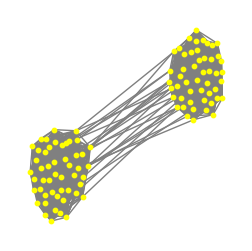

In [10]:
f, ax = plt.subplots(figsize=(3,3))
nx.draw(G, ax=ax, node_size=10, node_color="yellow", edge_color="grey")
plt.show()

In [12]:
evl, evc = find_evecs(nx.laplacian_matrix(G))
evl = np.real(evl)
evc = np.real(evc)

In [13]:
R = ermet.effective_resistance_matrix(G)
R_set = squareform(R.round(10))

B = ermet.biharmonic(G)
B_set = squareform(B.round(10))

In [14]:
R_tot_eigen = G.number_of_nodes()*np.sum(1/evl[1:])
R_tot = R.sum()
R_tot_set = R_set.sum()
R_tot_matrix = np.matrix(np.ones(R.shape[0]))*R*np.matrix(np.ones(R.shape[0])).T
R_tot_matrix = R_tot_matrix[0,0]


B_tot_eigen = G.number_of_nodes()*np.sum(1/(evl[1:]**2))
B_tot = B.sum()
B_tot_set = B_set.sum()
B_tot_matrix = np.matrix(np.ones(B.shape[0]))*B*np.matrix(np.ones(B.shape[0])).T
B_tot_matrix = B_tot_matrix[0,0]

In [15]:
R_tot_eigen, R_tot/2, R_tot_set, R_tot_matrix/2

(361.4979872587133, 361.49798725871375, 361.4979872558, 361.4979872587138)

In [16]:
B_tot_eigen, B_tot/2, B_tot_set, B_tot_matrix/2

(139.10263618897935, 139.10263618898128, 139.1026361866, 139.10263618898128)

It does not work with the current implementation of CT so far

## Little visualization of CTs, total (effective) REs and Diam Res calculated using 2 different functions

* Graph Clustering using Effective Resistance: https://drops.dagstuhl.de/opus/volltexte/2018/8369/pdf/LIPIcs-ITCS-2018-41.pdf
* Effective Resistance: https://www.nas.ewi.tudelft.nl/people/Piet/papers/LAA_2011_EffectiveResistance.pdf

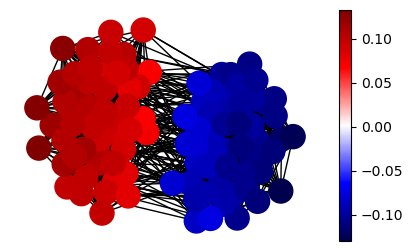

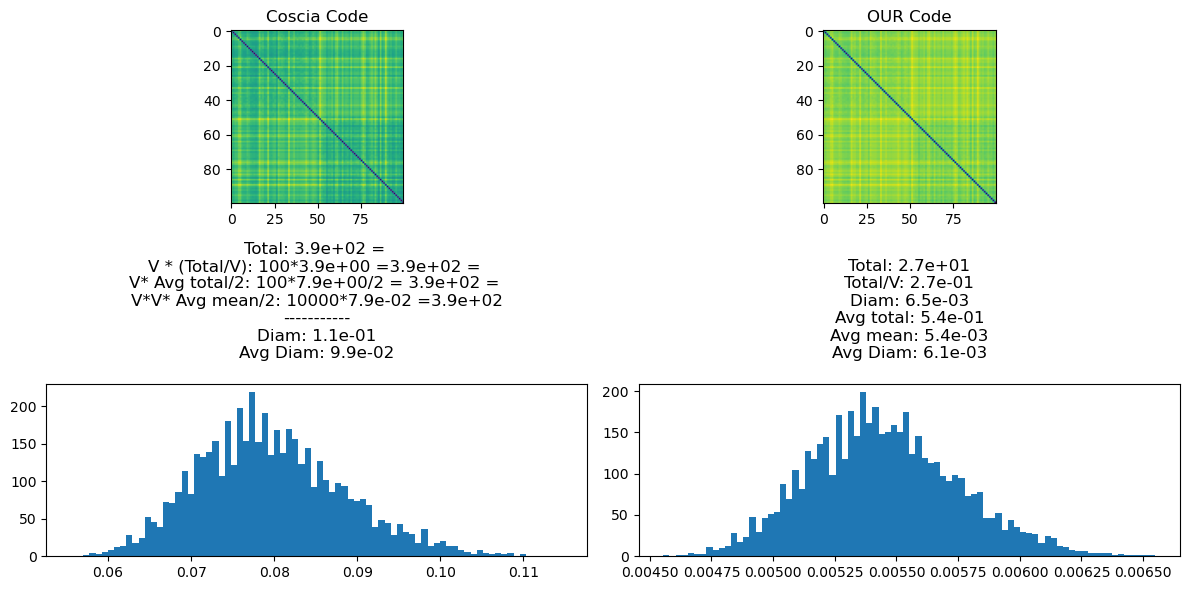

interactive(children=(FloatSlider(value=0.5, description='intra', max=1.0, min=0.1), FloatSlider(value=0.05, d…

In [17]:
@interact
def interactive_CT_SBM(intra=(0.1,1,0.1),inter=(0.0,0.1,0.01)):
    sizes = [50, 50]
    gap_prob = inter
    intra_prob = intra
    probs = [[intra_prob, gap_prob], [gap_prob, intra_prob]]
    G = nx.stochastic_block_model(sizes, probs)#, seed=0)
    
    evl, evc = find_evecs(nx.laplacian_matrix(G))
    evl = np.real(evl)
    evc = np.real(evc)
    
    fig, ax = plt.subplots(figsize=(5,3))
    plot_eigenvector_over_graph(G, evc, 1, ax)
    
    #Plot CTs
    f, axs = plt.subplots(2,2, figsize=(12,6))
    
    axs[0][0].imshow(ermet.effective_resistance_matrix(G))
    axs[0][0].set_title("Coscia Code")
    
    axs[0][1].imshow(commute_times(G, evl, evc, resistance = True))
    axs[0][1].set_title("OUR Code")

    cos_res = ermet.effective_resistance_matrix(G)
    axs[1][0].hist(cos_res[np.triu_indices(np.sum(sizes),k=1)].ravel(), bins=80)
    
    title = f"""Total: {ermet.total_effective_resistance(cos_res):.1e} = \n"""
    title += f"""V * (Total/V): {G.number_of_nodes()}*{ermet.total_effective_resistance(cos_res,mean = True):.1e} ="""
    title += f"""{G.number_of_nodes()*ermet.total_effective_resistance(cos_res,mean = True):.1e} = \n"""
    title += f"""V* Avg total/2: {G.number_of_nodes()}*{ermet.avg_node_total_er(cos_res):.1e}/2 = """
    title += f"""{G.number_of_nodes()*ermet.avg_node_total_er(cos_res)/2 :.1e} = \n"""
    title += f"""V*V* Avg mean/2: {G.number_of_nodes()**2}*{ermet.avg_node_mean_er(cos_res):.1e} ="""
    title += f"""{G.number_of_nodes()**2*ermet.avg_node_mean_er(cos_res)/2:.1e}\n"""
    title += "-----------\n"
    title += f"""Diam: {ermet.resistance_diameter(cos_res):.1e}\n"""
    title += f"""Avg Diam: {ermet.avg_node_max_distance(cos_res):.1e}\n"""
        
    axs[1][0].set_title(title)

    try:
        ct_res = commute_times(G, evl, evc, resistance = True)
        axs[1][1].hist(ct_res[np.triu_indices(np.sum(sizes),k=1)].ravel(), bins=80)
        title = f"""Total: {ermet.total_effective_resistance(ct_res):.1e}\n"""
        title += f"""Total/V: {ermet.total_effective_resistance(ct_res,mean = True):.1e}\n"""
        title += f"""Diam: {ermet.resistance_diameter(ct_res):.1e}\n"""
        title += f"""Avg total: {ermet.avg_node_total_er(ct_res):.1e}\n"""
        title += f"""Avg mean: {ermet.avg_node_mean_er(ct_res):.1e}\n"""
        title += f"""Avg Diam: {ermet.avg_node_max_distance(ct_res):.1e}\n"""
        
        axs[1][1].set_title(title)
    except:
        axs[1][1].text(0.5, 0.02, "Fail: NAN in CT computation", fontsize=18)
    
    plt.tight_layout()
    plt.show()

In [18]:
def plot_total_and_sum(loop_intra=True):
    sizes = [50, 50]
    
    cosc_res_list = {"total":[],"diam":[], "total_filtered":[]}
    ct_res_list = {"total":[],"diam":[], "total_filtered":[]}
    
    if loop_intra:
        loop_values = np.linspace(0.1,1,10)
        fixed_val=0.01
    else:
        loop_values = np.linspace(0.01,0.1,10)
        fixed_val=0.8
     
    for i in loop_values:
        gap_prob = fixed_val if loop_intra else i
        intra_prob = i if loop_intra else fixed_val
    
        probs = [[intra_prob, gap_prob], [gap_prob, intra_prob]]
        G = nx.stochastic_block_model(sizes, probs)#, seed=0)

        evl, evc = find_evecs(nx.laplacian_matrix(G))
        evl = np.real(evl)
        evc = np.real(evc)
        
        cos_res = ermet.effective_resistance_matrix(G)
        total= ermet.total_effective_resistance(cos_res)
        diam = ermet.resistance_diameter(cos_res)
        diam_f = np.std(ermet.node_total_er(cos_res, G, filtered=True))
        #diam_f = np.max(ermet.node_total_er(cos_res, G, filtered=True))
        cosc_res_list["total"].append(total) 
        cosc_res_list["diam"].append(diam)
        cosc_res_list["total_filtered"].append(diam_f)
        

        ct_res = commute_times(G, evl, evc, resistance = True)
        total = ermet.total_effective_resistance(ct_res)
        diam = ermet.resistance_diameter(ct_res)
        diam_f = ermet.total_effective_resistance(ct_res, G, filtered=True)
        diam_f = ermet.total_effective_resistance(ct_res, G, filtered=True)
        diam_f = np.std(ermet.node_total_er(ct_res, G, filtered=True))
        ct_res_list["total"].append(total) 
        ct_res_list["diam"].append(diam)
        ct_res_list["total_filtered"].append(diam_f)
        
    return cosc_res_list, ct_res_list, loop_values
    


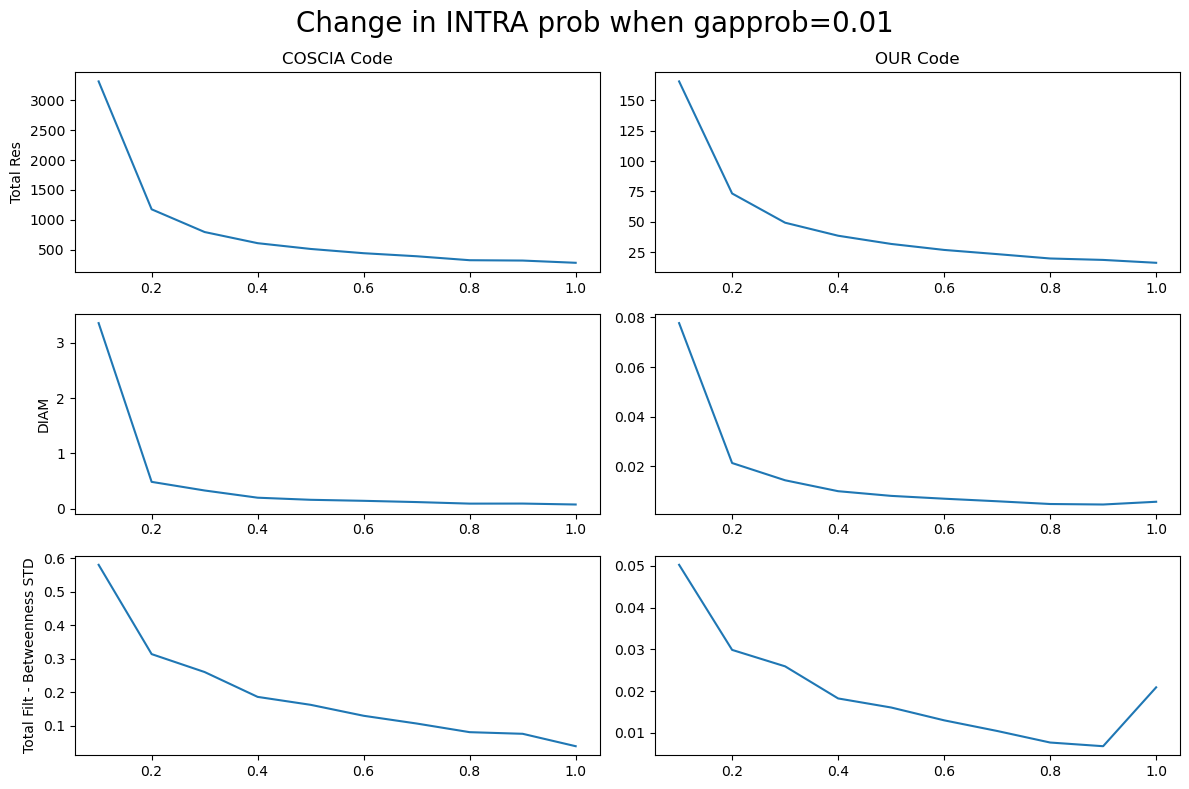

In [19]:
csdict, ctdict, xaxes = plot_total_and_sum(loop_intra=True)
f, axs = plt.subplots(3,2, figsize=(12,8))

axs[0][0].set_title('COSCIA Code')
axs[0][0].set_ylabel('Total Res')
axs[0][0].plot(xaxes, csdict['total'])
axs[0][1].set_title('OUR Code')
axs[0][1].plot(xaxes, ctdict['total'])

axs[1][0].set_ylabel('DIAM')
axs[1][0].plot(xaxes, csdict['diam'])
axs[1][1].plot(xaxes, ctdict['diam'])

axs[2][0].set_ylabel('Total Filt - Betweenness STD')
axs[2][0].plot(xaxes, csdict['total_filtered'])
axs[2][1].plot(xaxes, ctdict['total_filtered'])



plt.suptitle('Change in INTRA prob when gapprob=0.01', fontsize=20)
plt.tight_layout()
plt.show()

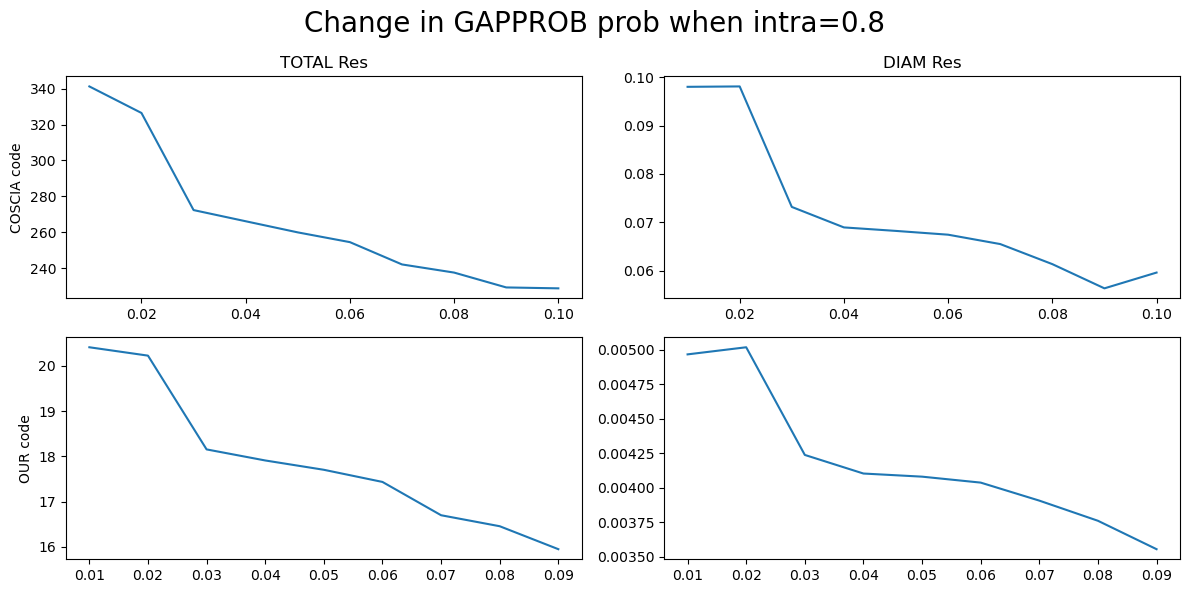

In [20]:
csdict, ctdict, xaxes = plot_total_and_sum(loop_intra=False)
f, axs = plt.subplots(2,2, figsize=(12,6))

axs[0][0].plot(xaxes, csdict['total'])
axs[0][0].set_title('TOTAL Res')
axs[0][0].set_ylabel('COSCIA code')
axs[0][1].plot(xaxes, csdict['diam'])
axs[0][1].set_title('DIAM Res')
axs[1][0].plot(xaxes, ctdict['total'])
axs[1][0].set_ylabel('OUR code')
axs[1][1].plot(xaxes, ctdict['diam'])


plt.suptitle('Change in GAPPROB prob when intra=0.8', fontsize=20)
plt.tight_layout()
plt.show()

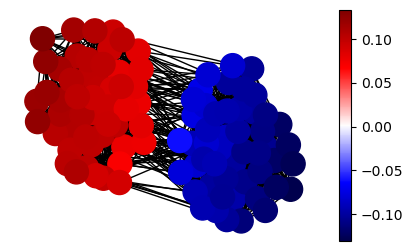

In [21]:
sizes = [50, 50]
gap_prob = 0.05
intra_prob = 0.5
probs = [[intra_prob, gap_prob], [gap_prob, intra_prob]]
G = nx.stochastic_block_model(sizes, probs)#, seed=0)

evl, evc = find_evecs(nx.laplacian_matrix(G))
evl = np.real(evl)
evc = np.real(evc)

fig, ax = plt.subplots(figsize=(5,3))
plot_eigenvector_over_graph(G, evc, 1, ax)

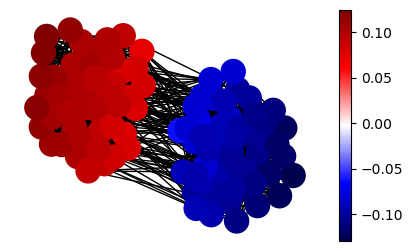

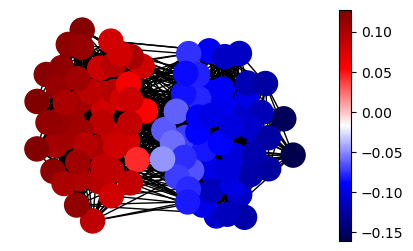

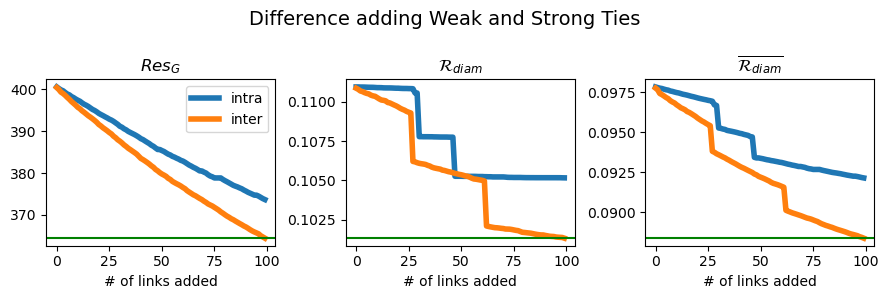

In [22]:
from random import choice

G_intra = G.copy()
G_inter = G.copy()
com1 = np.where(np.array(evc[:,1]).squeeze() < 0)[0]
com2 = np.where(np.array(evc[:,1]).squeeze() > 0)[0]

intra_data = {"total":[],"diam":[], "diam_filtered":[], "avg_node_diameter":[], "avg_node_total_er":[]}
inter_data = {"total":[],"diam":[], "diam_filtered":[], "avg_node_diameter":[], "avg_node_total_er":[]}

for i in range(100):
    
    u = choice(list(G.nodes()))
    v_intra = choice(com1) if evc[u,1]<0 else choice(com2)
    v_inter = choice(com2) if evc[u,1]<0 else choice(com1)
    
    while G.has_edge(u, v_intra) or G.has_edge(u, v_inter) or u == v_intra:
        v_intra = choice(com1) if evc[u,1]<0 else choice(com2)
        v_inter = choice(com2) if evc[u,1]<0 else choice(com1)

        
    G_intra.add_edge(u,v_intra)
    cos_res = ermet.effective_resistance_matrix(G_intra)
    total= ermet.total_effective_resistance(cos_res)
    diam = ermet.resistance_diameter(cos_res)
    diam_f = ermet.resistance_diameter(cos_res, G_intra, filtered=True)
    diam_avg = ermet.avg_node_max_distance(cos_res)

    intra_data["total"].append(total) 
    intra_data["diam"].append(diam)
    intra_data["diam_filtered"].append(diam_f)
    intra_data["avg_node_diameter"].append(diam_avg)
    
    if i % 1==0:
        G_inter.add_edge(u,v_inter)
        cos_res = ermet.effective_resistance_matrix(G_inter)
        total= ermet.total_effective_resistance(cos_res)
        diam = ermet.resistance_diameter(cos_res)
        diam_f= ermet.resistance_diameter(cos_res, G_inter, filtered=True)
        diam_avg = ermet.avg_node_max_distance(cos_res)

        inter_data["total"].append(total) 
        inter_data["diam"].append(diam)
        inter_data["diam_filtered"].append(diam_f)
        inter_data["avg_node_diameter"].append(diam_avg)
        

fig, ax = plt.subplots(figsize=(5,3))
evl, evc = find_evecs(nx.laplacian_matrix(G_intra))
evl = np.real(evl)
evc = np.real(evc)
plot_eigenvector_over_graph(G_intra, evc, 1, ax)

fig, ax = plt.subplots(figsize=(5,3))
evl, evc = find_evecs(nx.laplacian_matrix(G_inter))
evl = np.real(evl)
evc = np.real(evc)
plot_eigenvector_over_graph(G_inter, evc, 1, ax)    



f, axs = plt.subplots(1,3, figsize=(9,3))


axs[0].set_title('$Res_G$')
axs[0].set_xlabel('# of links added')
axs[0].plot(intra_data['total'], label='intra', linewidth=4)
axs[0].plot(inter_data['total'], label='inter', linewidth=4)
axs[0].legend()
axs[0].axhline(np.min([np.min(intra_data['total']),np.min(inter_data['total'])]),\
                 color='green')

axs[1].set_title('$\mathcal{R}_{diam}$')
axs[1].set_xlabel('# of links added')
axs[1].plot(intra_data['diam'], label='intra', linewidth=4)
axs[1].plot(inter_data['diam'], label='inter', linewidth=4)
axs[1].axhline(np.min([np.min(intra_data['diam']),np.min(inter_data['diam'])]),\
                 color='green')

axs[2].set_title('$\overline{\mathcal{R}_{diam}}$')
axs[2].set_xlabel('# of links added')
axs[2].plot(intra_data['avg_node_diameter'], label='intra', linewidth=4)
axs[2].plot(inter_data['avg_node_diameter'], label='inter', linewidth=4)
axs[2].axhline(np.min([np.min(intra_data['avg_node_diameter']),np.min(inter_data['avg_node_diameter'])]),\
                 color='green')


plt.suptitle('Difference adding Weak and Strong Ties', fontsize=14)
plt.tight_layout()
plt.show()

## Basic ER and CT embedding

In [24]:
# Create Synthetic graph
sizes = [50, 50]
gap_prob = 0.05
intra_prob = 0.8
probs = [[intra_prob, gap_prob], [gap_prob, intra_prob]]
G = nx.stochastic_block_model(sizes, probs)#, seed=0)

In [25]:
A = nx.adjacency_matrix(G)
L = nx.laplacian_matrix(G)
L_n = nx.normalized_laplacian_matrix(G)
print(f"""- Number of edges: {G.size()}""")

- Number of edges: 2056


**Coscia VS Our resistance: Proof of different properties and equalities** 

In [26]:
evl, evc = find_evecs(nx.laplacian_matrix(G))
evl = np.real(evl)
evc = np.real(evc)

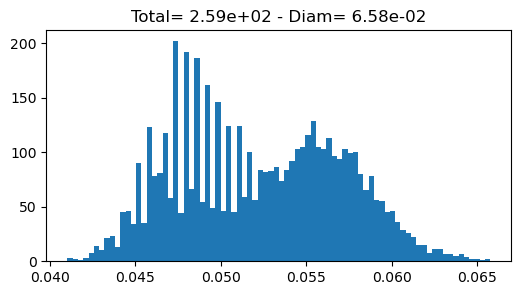

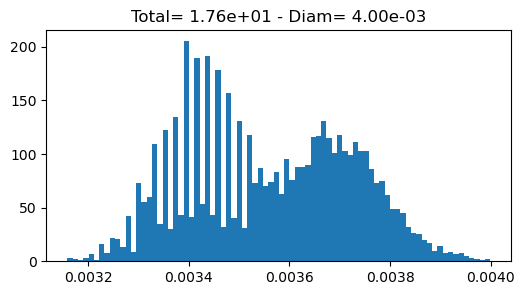

In [27]:
plt.figure(figsize=(6,3))
cos_res = ermet.effective_resistance_matrix(G)[np.triu_indices(G.number_of_nodes(),k=1)].ravel()
plt.hist(cos_res, bins=80)
total=np.sum(cos_res)
diam=np.max(cos_res)
plt.title(f"Total= {total:.2e} - Diam= {diam:.2e}")
plt.show()

plt.figure(figsize=(6,3))
ct_res = squareform(commute_times(G, evl, evc, resistance = True)).ravel()
plt.hist(ct_res, bins=80)
total=np.sum(ct_res)
diam=np.max(ct_res)
plt.title(f"Total= {total:.2e} - Diam= {diam:.2e}")
plt.show()

In [28]:
G.number_of_nodes()*np.sum(1/evl[1:])

258.82581756811544

In [29]:
filtered_cosc_res = ermet.effective_resistance_matrix(G)*A.toarray()
np.sum(filtered_cosc_res[np.triu_indices(G.number_of_nodes(),k=1)]), \
np.sum(ermet.effective_resistance_matrix(G)[np.triu_indices(G.number_of_nodes(),k=1)])

(99.0, 258.82581756811555)

In [30]:
filtered_ct_res = commute_times(G, evl, evc, resistance = True)*A.toarray()
np.sum(filtered_ct_res[np.triu_indices(G.number_of_nodes(),k=1)]), \
np.sum(commute_times(G, evl, evc, resistance = True)[np.triu_indices(G.number_of_nodes(),k=1)])

(7.032831368660808, 17.632732236753363)

**Plots**

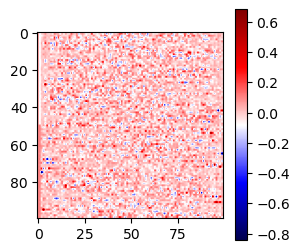

In [31]:
evl, evc = find_evecs(L)
evl = np.real(evl)
evc = np.real(evc)
fig, ax = plt.subplots(figsize=(3,3))
plt.imshow(evc, cmap='seismic')
plt.colorbar()
plt.show()

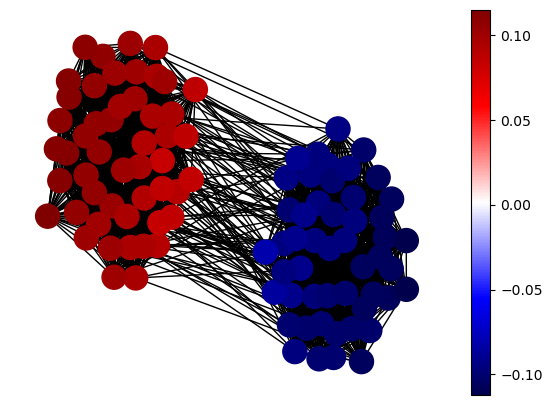

In [32]:
fig, ax = plt.subplots(figsize=(7,5))
plot_eigenvector_over_graph(G, evc, 1, ax)

Get commute times embedding and commute times distances

In [33]:
CTE = commute_times_embedding(G, evl, evc)
CT = commute_times(G, evl, evc)
Res = commute_times(G, evl, evc, resistance = True)
B = ermet.biharmonic(G).round(5)

Plot commute times distances

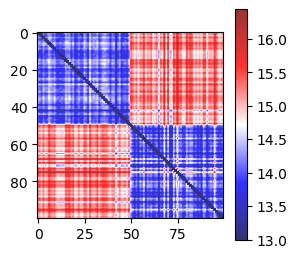

In [34]:
fig, ax = plt.subplots(figsize=(3,3))
plt.imshow(CT, alpha=0.8, cmap="seismic", vmin=squareform(CT).min(), vmax=squareform(CT).max())
#plt.imshow(Res, alpha=0.8, cmap="seismic")
plt.colorbar()
plt.show()

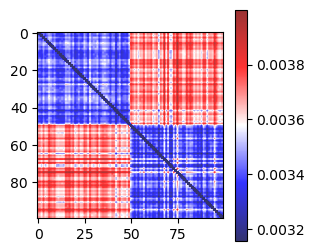

In [35]:
fig, ax = plt.subplots(figsize=(3,3))
plt.imshow(Res, alpha=0.8, cmap="seismic", vmin=squareform(Res).min(), vmax=squareform(Res).max())
#plt.imshow(Res, alpha=0.8, cmap="seismic")
plt.colorbar()
plt.show()

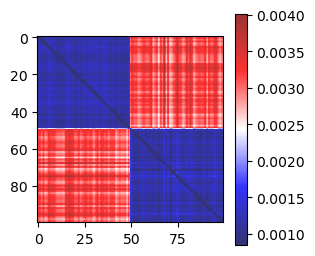

In [36]:
fig, ax = plt.subplots(figsize=(3,3))
plt.imshow(B, alpha=0.8, cmap="seismic", vmin=squareform(B).min(), vmax=squareform(B).max())
#plt.imshow(Res, alpha=0.8, cmap="seismic")
plt.colorbar()
plt.show()

In [37]:
import matplotlib as mpl

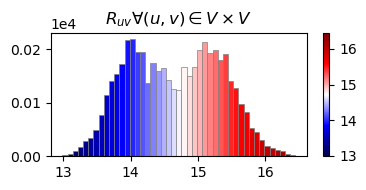

In [38]:
bns = int(np.sqrt(G.number_of_edges()))

fig, ax = plt.subplots(figsize=(4,2))
cm = plt.cm.get_cmap('seismic')
n, bins, patches = plt.hist(squareform(CT), 
                            bins = bns,
                            edgecolor='grey', linewidth=0.5)

norm = mpl.colors.Normalize(vmin=squareform(CT).min(), vmax=squareform(CT).max())
for c, p in zip(bins, patches):
    plt.setp(p, 'facecolor', cm(norm(c)))
sm = plt.cm.ScalarMappable(cmap="seismic", norm=plt.Normalize(vmin=squareform(CT).min(), vmax=squareform(CT).max()))
    #sm.set_array([])
cbar = plt.colorbar(sm)
plt.title(r'$R_{uv} \forall (u,v) \in V \times V$')
plt.ticklabel_format(axis='y', style='sci', scilimits=(4,4))
plt.tight_layout()
#fig.savefig('figs/FbAllRuvHist.pdf', dpi=300, bbox_inches='tight')
#plt.yscale('log')
plt.show()

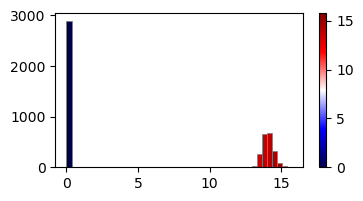

In [39]:
# Filtered distances
bns = int(np.sqrt(G.number_of_edges()))

fig, ax = plt.subplots(figsize=(4,2))
cm = plt.cm.get_cmap('seismic')
n, bins, patches = plt.hist(squareform((CT*A.toarray())), 
                            bins = bns,
                            edgecolor='grey', linewidth=0.5)

norm = mpl.colors.Normalize(vmin=squareform((CT*A.toarray())).min(), vmax=squareform((CT*A.toarray())).max())
for c, p in zip(bins, patches):
    plt.setp(p, 'facecolor', cm(norm(c)))
sm = plt.cm.ScalarMappable(cmap="seismic", norm=plt.Normalize(vmin=squareform((CT*A.toarray())).min(), vmax=squareform((CT*A.toarray())).max()))
    #sm.set_array([])
cbar = plt.colorbar(sm)

plt.show()

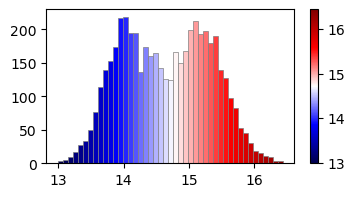

In [40]:
bns = int(np.sqrt(G.number_of_edges()))

fig, ax = plt.subplots(figsize=(4,2))
cm = plt.cm.get_cmap('seismic')
n, bins, patches = plt.hist(squareform(CT), 
                            bins = bns,
                            edgecolor='grey', linewidth=0.5)

norm = mpl.colors.Normalize(vmin=squareform(CT).min(), vmax=squareform(CT).max())
for c, p in zip(bins, patches):
    plt.setp(p, 'facecolor', cm(norm(c)))
sm = plt.cm.ScalarMappable(cmap="seismic", norm=plt.Normalize(vmin=squareform(CT).min(), vmax=squareform(CT).max()))
    #sm.set_array([])
cbar = plt.colorbar(sm)

plt.show()

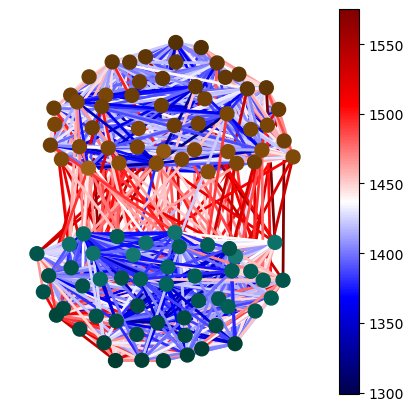

In [41]:
fig, ax = plt.subplots(figsize=(5,5))
opt = {
    "node_color": np.array(evc[:,1]).ravel(),
    "width": 2,
     "cmap": plt.cm.BrBG,
    "edge_cmap": plt.cm.seismic,
    "with_labels": False,
    "node_size": 100,
}
plot_commute_times_over_graph(G, evl, evc, ax, options=opt, CT=None)

Plot Commute Times Embedding

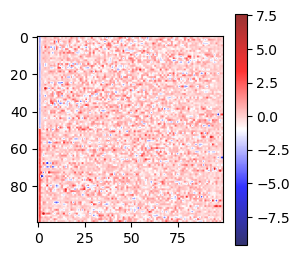

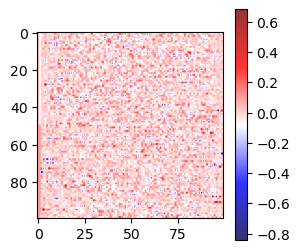

In [42]:
fig, ax = plt.subplots(figsize=(3,3))
plt.imshow(np.transpose(CTE), alpha=0.8, cmap="seismic")
plt.colorbar()
plt.show()

fig, ax = plt.subplots(figsize=(3,3))
plt.imshow(evc, alpha=0.8, cmap="seismic")
plt.colorbar()
plt.show()

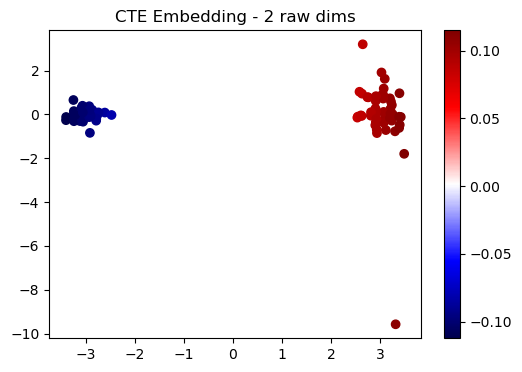

In [43]:
#from sklearn.manifold import TSNE
fig, ax = plt.subplots(figsize=(6,4))
CTE_T = np.array(np.transpose(CTE))
im = ax.scatter(CTE_T[:,1], CTE_T[:,2], c=np.array(np.real(evc[:,1])), cmap=plt.cm.seismic)
plt.title("CTE Embedding - 2 raw dims")
fig.colorbar(im, ax=ax)
plt.show()

In [44]:
import umap

In [45]:
reducer = umap.UMAP()
CTE_2d = reducer.fit_transform(CTE_T)
CTE_2d.shape

(100, 2)

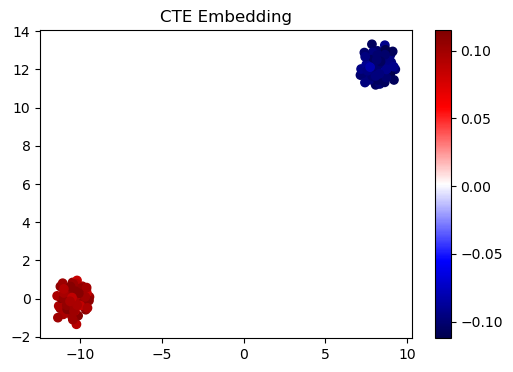

In [46]:
#CTE_2d = TSNE(n_components=2, learning_rate='auto',
#            init='random', perplexity=3, early_exaggeration=3).fit_transform(CTE_T)

fig, ax = plt.subplots(figsize=(6,4))
im = ax.scatter(CTE_2d[:,0], CTE_2d[:,1], c=np.array(np.real(evc[:,1])), cmap=plt.cm.seismic)
plt.title("CTE Embedding")
fig.colorbar(im, ax=ax)

Same raw and dimensionaly reducted eigen

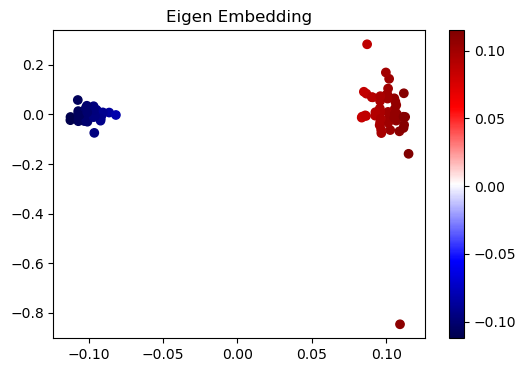

In [47]:
fig, ax = plt.subplots(figsize=(6,4))
im = ax.scatter(np.array(evc[:,1]), np.array(evc[:,2]), c=np.array(np.real(evc[:,1])), cmap=plt.cm.seismic)
plt.title("Eigen Embedding")
fig.colorbar(im, ax=ax)
plt.show()

In [48]:
reducer = umap.UMAP()
eigen_2d = reducer.fit_transform(np.asarray(evc))
eigen_2d.shape

(100, 2)

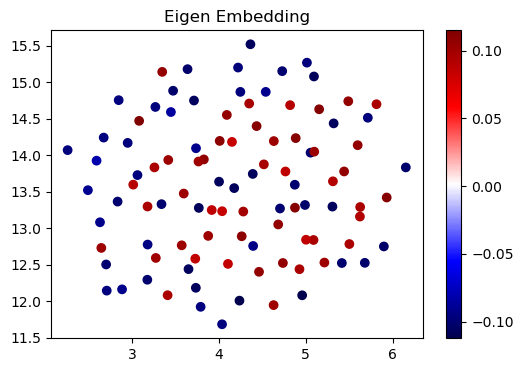

In [49]:
#eigen_2d = TSNE(n_components=2, learning_rate='auto', perplexity=5).fit_transform(evc)

fig, ax = plt.subplots(figsize=(6,4))
im = ax.scatter(eigen_2d[:,0], eigen_2d[:,1], c=np.array(np.real(evc[:,1])), cmap=plt.cm.seismic)
plt.title("Eigen Embedding")
fig.colorbar(im, ax=ax)

## Structural Link Predictor by CT

**See GAE:** https://github.com/tkipf/gae/blob/0ebbe9b9a8f496eb12deb9aa6a62e7016b5a5ac3/gae/layers.py#L107

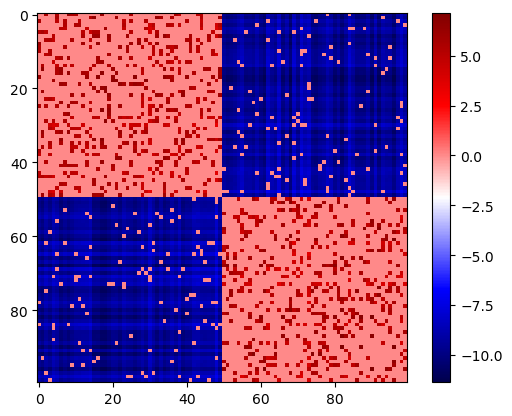

In [50]:
#Prediction
ZZT = np.array(np.matmul(CTE_T,CTE))
np.fill_diagonal(ZZT,0)

#Identify non-existing links
notA = 1-nx.to_numpy_array(G)
np.fill_diagonal(notA, 0)
notA


plt.imshow(ZZT*notA, cmap=plt.cm.seismic)
plt.colorbar()

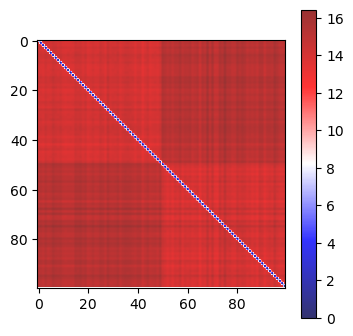

In [51]:
fig, ax = plt.subplots(figsize=(4,4))
plt.imshow(CT, alpha=0.8, cmap="seismic")
#plt.imshow(Res, alpha=0.8, cmap="seismic")
plt.colorbar()
plt.show()

# Examples of the proposed metrics

In [69]:
import utils.data_loader as loader

**Whole FB - However same BCC**

**Facebook subset from https://arxiv.org/pdf/2204.09888.pdf**

In [70]:
adj, features, labels, idx_train, idx_val, idx_test, sens = loader.process_facebook('data/facebook')

# Depending Netx version
#FB = nx.from_numpy_matrix(adj)
FB = nx.from_numpy_array(adj)

Gcc = sorted(nx.connected_components(FB), key=len, reverse=True)
G = nx.Graph(FB.subgraph(Gcc[0]))

sensitive_group = sens[np.array(list(Gcc[0]))]

index_to_node = {index: node for index, node in enumerate(G.nodes())}
G = nx.relabel_nodes(G, {node:ix for ix, node in enumerate(G.nodes())}, copy=True)

G.number_of_nodes(), G.number_of_edges(), (len(sens[sens==1]), len(sens[sens==0]))

['264', 'gender;anonymized', 'feature', '77']
['265', 'gender;anonymized', 'feature', '78']


(1034, 26749, (357, 688))

In [71]:
len(list(FB.nodes())), len(list(G.nodes)), len(list(FB.edges())), len(list(G.edges()))

(1045, 1034, 26749, 26749)

**Add here your graph**

In [358]:
G = nx.powerlaw_cluster_graph(300, 3, .95)

**Experiment**

In [355]:
L = nx.laplacian_matrix(G)
A = nx.adjacency_matrix(G)
evl, evc = find_evecs(L)
evl = np.real(evl)
evc = np.real(evc)
index_to_node = {index: node for index, node in enumerate(G.nodes())}

In [360]:
pos = nx.kamada_kawai_layout(G)
pos2= {n:np.array([pos[n][1], pos[n][0]]) for n in pos}

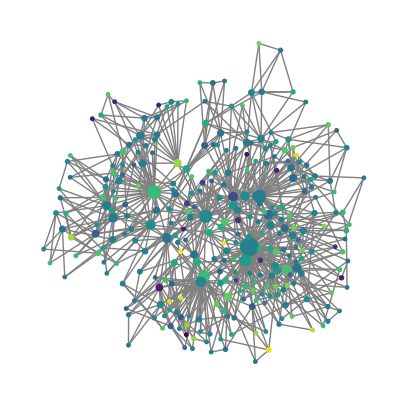

In [363]:
f, ax = plt.subplots(figsize=(5,5))
options = {
    "node_color": np.array(evc[:,1]).ravel()+10,
    "edge_color": 'grey',
    "width": 1,
    "node_size":np.array([itm[1] for itm in dict(G.degree).items()])*2,
    "edge_cmap": plt.cm.seismic,
    "cmap": plt.cm.viridis,
    "with_labels": False,
}
# Draw the graph
nx.draw(G, pos, **options, ax=ax)
plt.axis('off')
plt.show()

In [364]:
original_res = ermet.effective_resistance_matrix(G)
original_CT = commute_times(G, evl, evc, resistance = True)

In [365]:
G.number_of_nodes()*np.sum(1/evl[1:]), \
np.sum(original_res[np.triu_indices(np.sum(G.number_of_nodes()),k=1)])

(28331.501667303597, 29361.70042261213)

In [366]:
def plt_ct_wrt_node(G, idx, CT, cmap='viridis', er_max=None, er_min=None):
    plt.figure(figsize=(9,6))
    nx.draw_networkx_nodes(G, pos=pos, 
                           node_size=40, 
                           nodelist=list(G.nodes),
                           vmin = er_min,
                           vmax = er_max,
                           node_color=CT[idx,:],
                           cmap=cmap,
                           edgecolors=None,
                           label='CT distance')
    nx.draw_networkx_nodes(G, pos=pos, 
                           node_size=100,
                           nodelist=[idx], 
                           node_color='red',
                           edgecolors='black', 
                           node_shape = 'v',
                           label='Source node')
    nx.draw_networkx_edges(G, pos=pos, edge_color='grey')
    plt.legend()
    
    er_min = CT[idx,:].min() if er_min is None else er_min
    er_max = CT[idx,:].max() if er_max is None else er_max
    sm = plt.cm.ScalarMappable(cmap=cmap, 
                            norm=plt.Normalize(vmin=er_min, vmax=er_max))
    plt.axis('off')
    cbar = plt.colorbar(sm)
    plt.show()

In [367]:
edge_diameter = np.unravel_index(np.argmax(original_res), shape=original_res.shape)
edge_diameter = (index_to_node[edge_diameter[0]], index_to_node[edge_diameter[1]])
node_source_idx = edge_diameter[0]
node_destiny = edge_diameter[1]
node_source_idx, node_destiny

(197, 281)

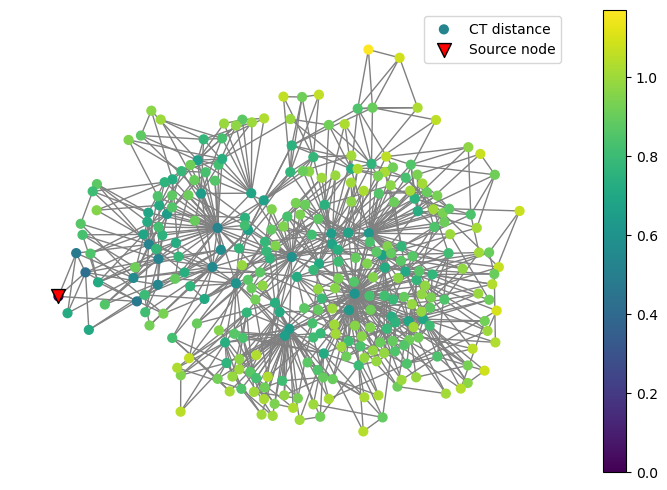

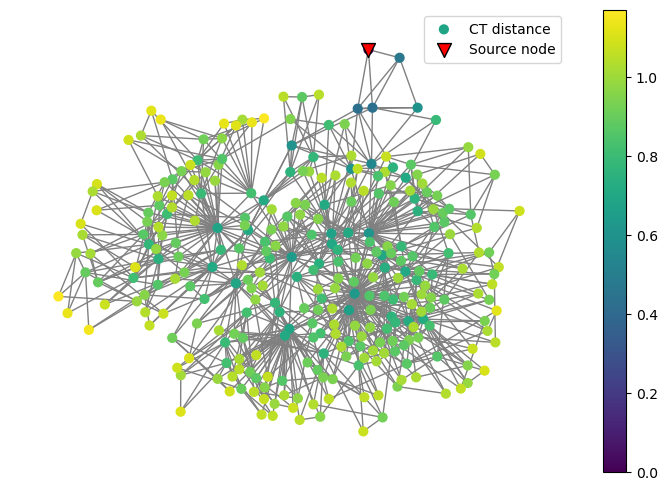

In [368]:
original_res = ermet.effective_resistance_matrix(G)
#original_CT = commute_times(G, evl, evc, resistance = True)
plt_ct_wrt_node(G, node_source_idx, original_res)
#plt_ct_wrt_node(G, node_idx, original_CT)

#Destiny
plt_ct_wrt_node(G, node_destiny, original_res)

In [369]:
G.add_edge(node_source_idx, node_destiny)
node_source_idx, node_destiny

(197, 281)

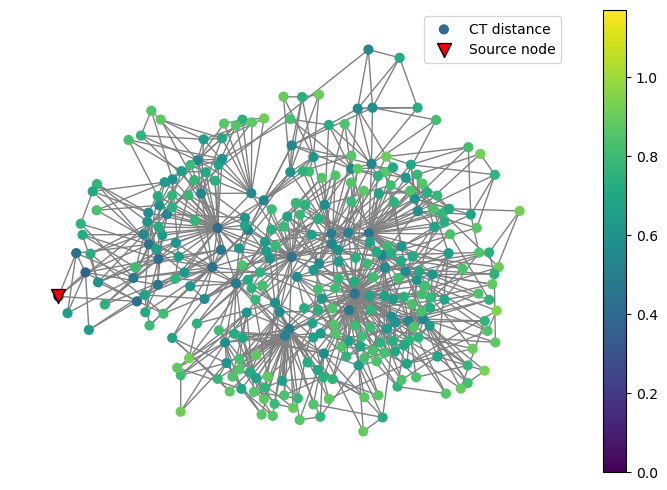

In [370]:
rw_res = ermet.effective_resistance_matrix(G)
plt_ct_wrt_node(G, node_source_idx, rw_res, 
                er_min=original_res[node_source_idx,:].min(),
                er_max=original_res[node_source_idx,:].max())

Let's add the most probable link instead: minimun ER that is not already a link

In [371]:
G.remove_edge(node_source_idx, node_destiny)

**Histogram of Nodes distances and node metrics and Graph distances and metrics**

In [372]:
bins = int(np.sqrt(G.number_of_nodes())/2)

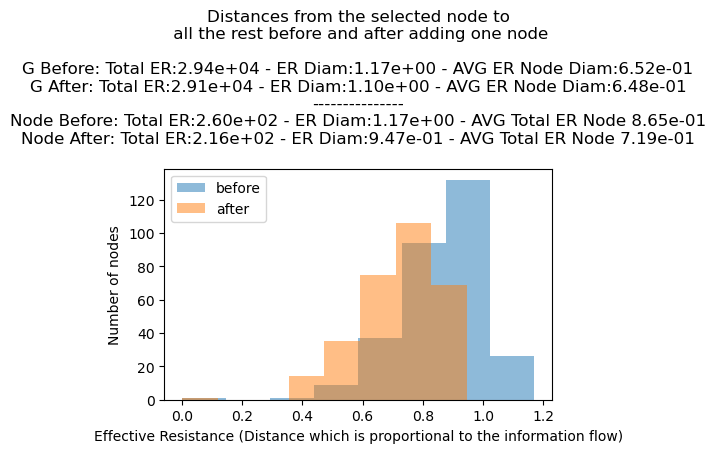

In [373]:
plt.figure(figsize=(5,3))
plt.hist(original_res[node_source_idx,:],alpha=0.5,bins=bins, label='before')
plt.hist(rw_res[node_source_idx,:],alpha=0.5,bins=bins, label='after')
plt.legend()

title = "Distances from the selected node to\n all the rest before and after adding one node\n\n"
total = ermet.total_effective_resistance(original_res)
diam = ermet.resistance_diameter(original_res)
avg_diam = ermet.avg_node_mean_er(original_res)
title+=f"G Before: Total ER:{total:.2e} - ER Diam:{diam:.2e} - AVG ER Node Diam:{avg_diam:.2e}\n"

total = ermet.total_effective_resistance(rw_res)
diam = ermet.resistance_diameter(rw_res)
avg_diam = ermet.avg_node_mean_er(rw_res)
title+=f"G After: Total ER:{total:.2e} - ER Diam:{diam:.2e} - AVG ER Node Diam:{avg_diam:.2e}\n"
title+='---------------\n'

total = ermet.node_total_er(original_res)[node_source_idx]
diam = ermet.node_diameters(original_res)[node_source_idx]
avg_total = ermet.node_mean_er(original_res)[node_source_idx]
title+=f"Node Before: Total ER:{total:.2e} - ER Diam:{diam:.2e} - AVG Total ER Node {avg_total:.2e}\n"

total = ermet.node_total_er(rw_res)[node_source_idx]
diam = ermet.node_diameters(rw_res)[node_source_idx]
avg_total = ermet.node_mean_er(rw_res)[node_source_idx]
title+=f"Node After: Total ER:{total:.2e} - ER Diam:{diam:.2e} - AVG Total ER Node {avg_total:.2e}\n"

plt.title(title)

plt.xlabel("Effective Resistance (Distance which is proportional to the information flow)")
plt.ylabel("Number of nodes")
plt.show()

In [374]:
bins = int(np.sqrt(G.number_of_edges())/2)

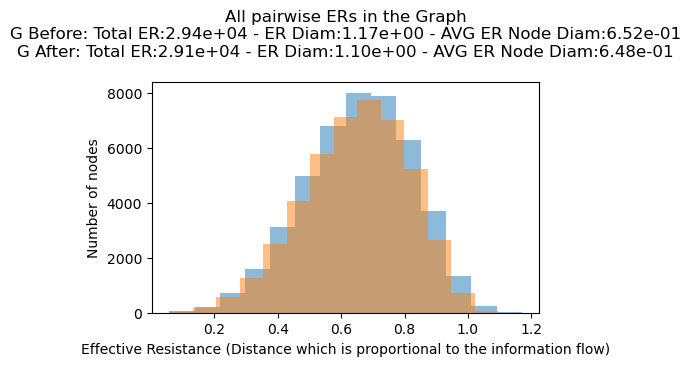

In [375]:
plt.figure(figsize=(5,3))
plt.hist(original_res[np.triu_indices(np.sum(G.number_of_nodes()),k=1)],alpha=0.5,bins=bins, label='before')
plt.hist(rw_res[np.triu_indices(np.sum(G.number_of_nodes()),k=1)],alpha=0.5,bins=bins, label='after')

title = "All pairwise ERs in the Graph\n"

total = ermet.total_effective_resistance(original_res)
diam = ermet.resistance_diameter(original_res)
avg_diam = ermet.avg_node_mean_er(original_res)
title+=f"G Before: Total ER:{total:.2e} - ER Diam:{diam:.2e} - AVG ER Node Diam:{avg_diam:.2e}\n"

total = ermet.total_effective_resistance(rw_res)
diam = ermet.resistance_diameter(rw_res)
avg_diam = ermet.avg_node_mean_er(rw_res)
title+=f"G After: Total ER:{total:.2e} - ER Diam:{diam:.2e} - AVG ER Node Diam:{avg_diam:.2e}\n"


plt.title(title)

plt.xlabel("Effective Resistance (Distance which is proportional to the information flow)")
plt.ylabel("Number of nodes")
plt.show()

In [376]:
bins= int(np.sqrt(G.number_of_nodes()))

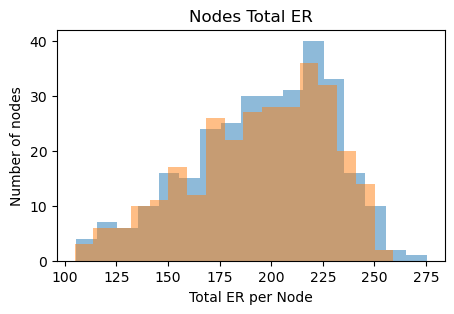

In [377]:
plt.figure(figsize=(5,3))
total_ers_bef = ermet.node_total_er(original_res)
total_ers_aft = ermet.node_total_er(rw_res)

plt.hist(total_ers_bef,alpha=0.5,bins=bins, label='before')
plt.hist(total_ers_aft,alpha=0.5,bins=bins, label='after')

title = "Nodes Total ER"

plt.title(title)

plt.xlabel("Total ER per Node")
plt.ylabel("Number of nodes")
plt.show()

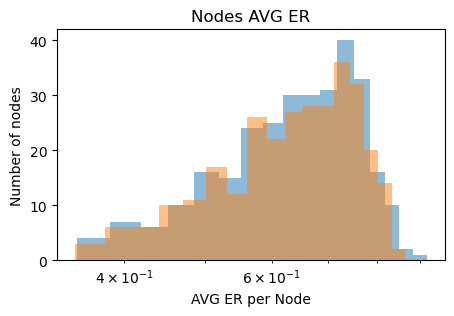

In [378]:
plt.figure(figsize=(5,3))
avg_ers_bef = ermet.node_mean_er(original_res)
avg_ers_aft = ermet.node_mean_er(rw_res)

plt.hist(avg_ers_bef,alpha=0.5,bins=bins, label='before')
plt.hist(avg_ers_aft,alpha=0.5,bins=bins, label='after')

title = "Nodes AVG ER"

plt.title(title)
plt.xscale('log')
plt.xlabel("AVG ER per Node")
plt.ylabel("Number of nodes")
plt.show()

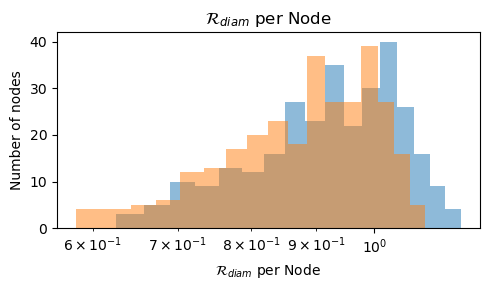

In [380]:
plt.figure(figsize=(5,3))
diam_nodes_bef = ermet.node_diameters(original_res)
diam_nodes_aft = ermet.node_diameters(rw_res)

plt.hist(diam_nodes_bef,alpha=0.5,bins=bins, label='before')
plt.hist(diam_nodes_aft,alpha=0.5,bins=bins, label='after')

title = "$\mathcal{R}_{diam}$ per Node"

plt.title(title)

plt.xlabel("$\mathcal{R}_{diam}$ per Node")
plt.ylabel("Number of nodes")
plt.xscale('log')
plt.tight_layout()
plt.show()

## General Graph Statistics

Show metrics

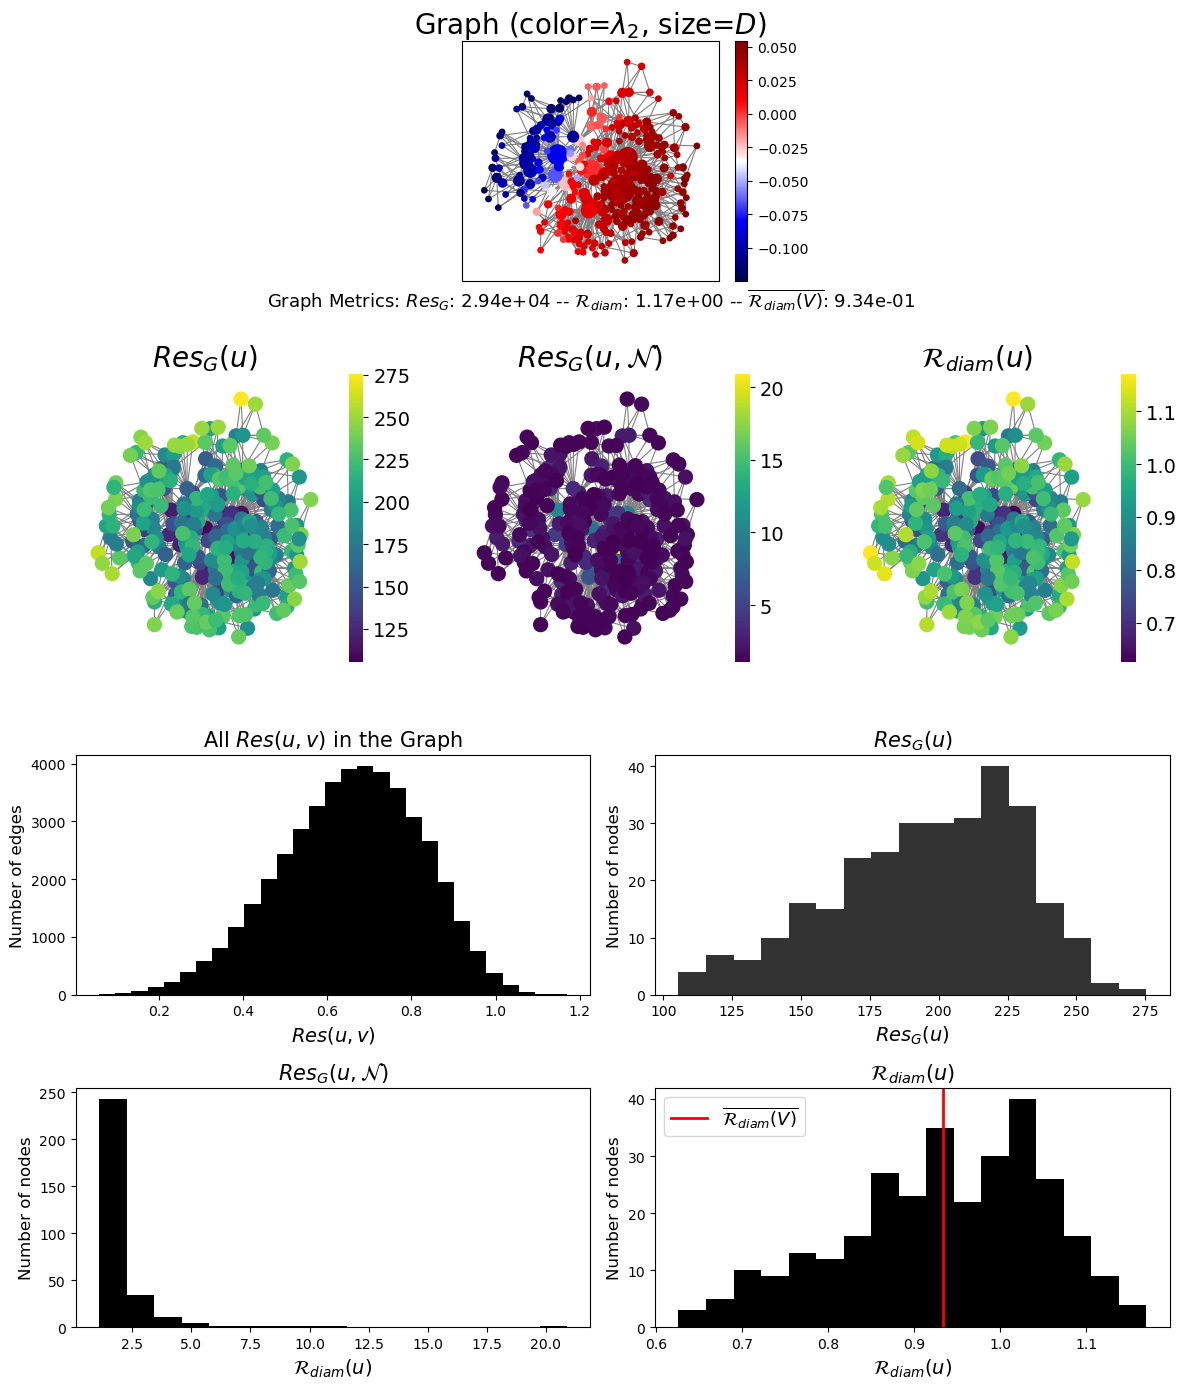

In [381]:
vis.graph_summary_metrics(G, pos=pos)

## Adding edges

In [382]:
def add_edges_dynamic(G, number_of_edges, ratio=1, rand = False):
    
    def add_metrics(R, G, met_dict):
        total= ermet.total_effective_resistance(R)
        diam = ermet.resistance_diameter(R)
        diam_avg = ermet.avg_node_max_distance(R)
        node_betw = ermet.node_total_er(R, G, filtered=True)
        max_bet = np.max(node_betw)
        avg_bet = np.mean(node_betw)
        std_bet = np.std(node_betw)
        
        #save data
        met_dict["total"].append(total)
        met_dict["diam"].append(diam)
        met_dict["avg_diam"].append(diam_avg)
        met_dict["max_bet"].append(max_bet)
        met_dict["avg_bet"].append(avg_bet)
        met_dict["std_bet"].append(std_bet)
    
    strong_data = {"total":[],"diam":[], "avg_diam":[], "max_bet":[], "avg_bet":[], "std_bet":[]}
    rand_data = {"total":[],"diam":[], "avg_diam":[], "max_bet":[], "avg_bet":[], "std_bet":[]}
    weak_data = {"total":[],"diam":[], "avg_diam":[], "max_bet":[], "avg_bet":[], "std_bet":[]}
    
    G_strong = G.copy()
    index_to_node_strong = {index: node for index, node in enumerate(G_strong.nodes())}
    G_rand = G.copy()
    index_to_node_random = {index: node for index, node in enumerate(G_rand.nodes())}
    G_weak = G.copy()
    index_to_node_weak = {index: node for index, node in enumerate(G_weak.nodes())}
        
    for i in tqdm(range(number_of_edges)):
        cos_res_strong = ermet.effective_resistance_matrix(G_strong)
        add_metrics(cos_res_strong, G_strong, strong_data)
        
        if rand:
            cos_res_rand = ermet.effective_resistance_matrix(G_rand)
            add_metrics(cos_res_rand, G_rand, rand_data)
        
        if i % ratio == 0:
            cos_res_weak = ermet.effective_resistance_matrix(G_weak)
            add_metrics(cos_res_weak, G_weak, weak_data)

        #add strong link
        G_strong = rew.add_strong_link(G_strong, cos_res_strong)
        if rand:
            G_rand = rew.add_rand_link(G_rand, cos_res_rand)
        if i % ratio == 0:
            G_weak = rew.add_weak_link(G_weak, cos_res_weak)
        
        
    cos_res_strong = ermet.effective_resistance_matrix(G_strong)
    add_metrics(cos_res_strong, G_strong, strong_data)
    cos_res_rand = ermet.effective_resistance_matrix(G_rand)
    add_metrics(cos_res_rand, G_rand, rand_data)
    cos_res_weak = ermet.effective_resistance_matrix(G_weak)
    add_metrics(cos_res_weak, G_weak, weak_data)    
    
    if rand:
        return G_strong, G_weak, G_rand, strong_data, weak_data, rand_data
    else:
        return G_strong, G_weak, strong_data, weak_data

    
    return G_strong, G_weak, G_rand, strong_data, weak_data, rand_data

In [383]:
number_of_added_links = 30
G1, G2, G3, intra_data, inter_data, rand_data = add_edges_dynamic(G, number_of_added_links, ratio=1, rand=True)
G.number_of_edges(), G1.number_of_edges(), G2.number_of_edges(), G3.number_of_edges()

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  9.72it/s]


(891, 921, 921, 921)

Show statistics

In [384]:
G1_diff_edges = list(G.edges() ^ G1.edges())
G2_diff_edges = list(G.edges() ^ G2.edges())
G3_diff_edges = list(G.edges() ^ G3.edges())

In [385]:
G.number_of_edges(), G1.number_of_edges(), G2.number_of_edges(), G3.number_of_edges()

(891, 921, 921, 921)

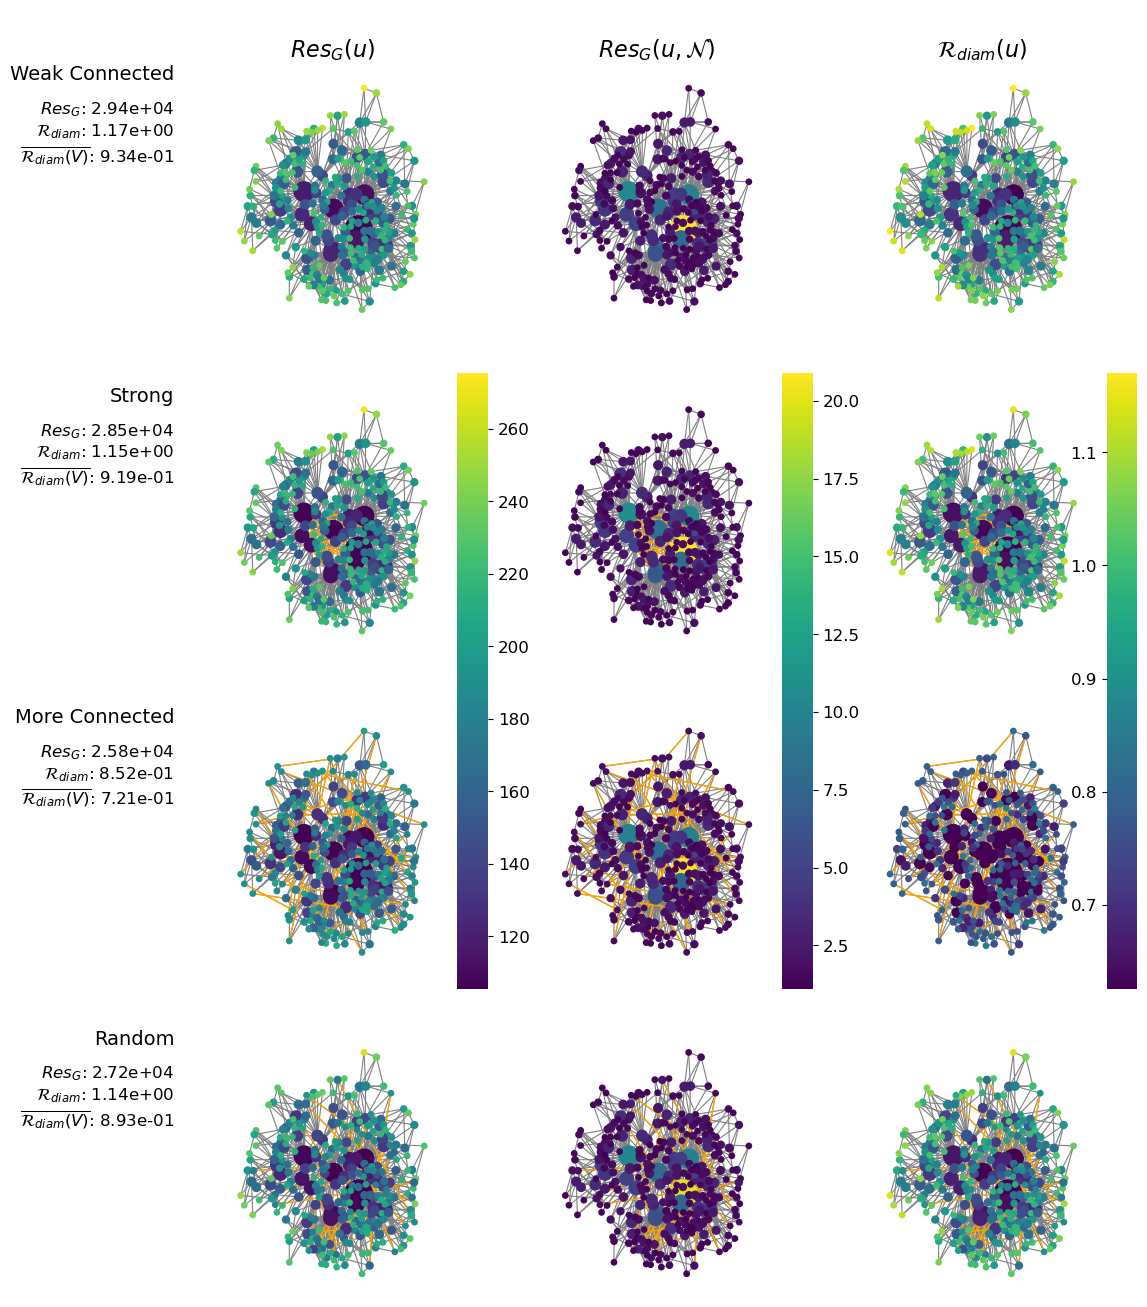

In [386]:
vis.compare_graphs([G, G1, G2, G3],
               graph_names=['Weak Connected', 'Strong', 'More Connected', 'Random'],
               pos=pos,
              edge_highlight=True,
              save=False)

Print 4 versions of the graph. new links as orange

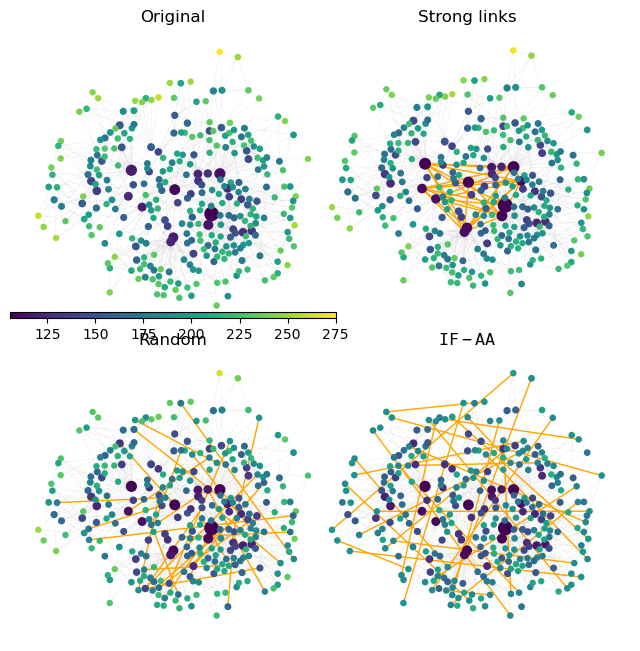

In [387]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

A= nx.adjacency_matrix(G)
f, axs = plt.subplots(2,2, figsize=(8,8))
options = {
    "edge_color": 'grey',
    "width": 0.05,
    "edge_cmap": plt.cm.seismic,
    "cmap": plt.cm.viridis,
    "with_labels": False,
}

axs = axs.ravel()
aux=10

G1_diff_edges = list(G.edges() ^ G1.edges())
G2_diff_edges = list(G.edges() ^ G2.edges())
G3_diff_edges = list(G.edges() ^ G3.edges())

ori_cos_res = ermet.node_total_er(ermet.effective_resistance_matrix(G))
strong_cos_res = ermet.node_total_er(ermet.effective_resistance_matrix(G1))
weak_cos_res = ermet.node_total_er(ermet.effective_resistance_matrix(G2))
rand_cos_res = ermet.node_total_er(ermet.effective_resistance_matrix(G3))

#ori_cos_res = ermet.node_total_er(ermet.effective_resistance_matrix(G), G, filtered=True)
#strong_cos_res = ermet.node_total_er(ermet.effective_resistance_matrix(G1), G1, filtered=True)
#weak_cos_res = ermet.node_total_er(ermet.effective_resistance_matrix(G2), G2, filtered=True)
#rand_cos_res = ermet.node_total_er(ermet.effective_resistance_matrix(G3), G3, filtered=True)

#ori_cos_res = ermet.node_diameters(ermet.effective_resistance_matrix(G))
#strong_cos_res = ermet.node_diameters(ermet.effective_resistance_matrix(G1))
#weak_cos_res = ermet.node_diameters(ermet.effective_resistance_matrix(G2))
#rand_cos_res = ermet.node_diameters(ermet.effective_resistance_matrix(G3))

axs[0].set_title("Original", pad=-10)
nx.draw(G, pos, ax = axs[0], **options,
       node_size = [d+aux for n,d in G.degree()],
       node_color=ori_cos_res,
       vmin =ori_cos_res.min() , vmax=ori_cos_res.max())

axs[1].set_title("Strong links", pad=-10)
nx.draw(G1, pos, ax = axs[1], **options,
        node_size = [d+aux for n,d in G1.degree()],
       node_color=strong_cos_res,
       vmin =ori_cos_res.min() , vmax=ori_cos_res.max())
nx.draw_networkx_edges(G1, edgelist = G1_diff_edges, pos=pos, edge_color='orange', ax = axs[1])

axs[2].set_title("Random", pad=-10)
nx.draw(G3, pos, ax = axs[2], **options,
        node_size = [d+aux for n,d in G3.degree()],
       node_color=rand_cos_res,
       vmin =ori_cos_res.min() , vmax=ori_cos_res.max())
nx.draw_networkx_edges(G3, edgelist = G3_diff_edges, pos=pos, edge_color='orange', ax = axs[2])

axs[3].set_title("$\mathtt{IF-AA}$", pad=-10)
nx.draw(G2, pos, ax = axs[3], **options,
        node_size = [d+aux for n,d in G2.degree()],
       node_color=weak_cos_res,
       vmin =ori_cos_res.min() , vmax=ori_cos_res.max())
nx.draw_networkx_edges(G2, edgelist = G2_diff_edges, pos=pos, edge_color='orange', ax = axs[3])


plt.subplots_adjust(wspace=-0.1, hspace=0.1)

sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, 
                            norm=plt.Normalize(vmin=np.min(ori_cos_res), vmax=np.max(ori_cos_res)))
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("bottom", size="2%", pad = -0.2)
plt.colorbar(sm, cax=cax, orientation='horizontal')
#plt.tight_layout()
#f.savefig('RewiredVersion.pdf', dpi=300, bbox_inches='tight')
plt.show()

Print rate of decreasing

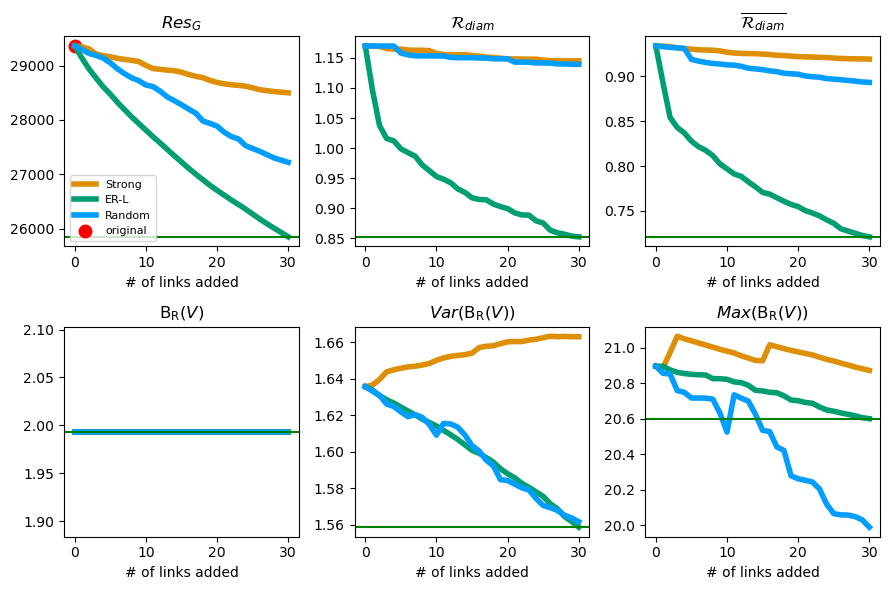

In [388]:
f, axs = plt.subplots(2,3, figsize=(9,6))

axs=axs.ravel()

orange = (222/255,143/255,5/255)
green = (2/255,158/255,115/255)
blue = (2/255,158/255,255/255)



axs[0].set_title('$Res_G$')
axs[0].set_xlabel('# of links added')
axs[0].plot(intra_data['total'], label='Strong', linewidth=4, color=orange)
axs[0].plot(inter_data['total'], label='ER-L', linewidth=4, color=green)
axs[0].plot(rand_data['total'], label='Random', linewidth=4, color=blue)
axs[0].scatter(0, np.max(intra_data['total']), label='original', linewidth=4, color='r')
axs[0].legend(fontsize=8)
axs[0].axhline(np.min([np.min(intra_data['total']),np.min(inter_data['total'])]),\
                 color='green')

axs[1].set_title('$\mathcal{R}_{diam}$')
axs[1].set_xlabel('# of links added')
axs[1].plot(intra_data['diam'], label='intra', linewidth=4, color=orange)
axs[1].plot(inter_data['diam'], label='inter', linewidth=4, color=green)
axs[1].plot(rand_data['diam'], label='rand', linewidth=4, color=blue)
axs[1].axhline(np.min([np.min(intra_data['diam']),np.min(inter_data['diam'])]),\
                 color='green')


axs[2].set_title('$\overline{\mathcal{R}_{diam}}$')
axs[2].set_xlabel('# of links added')
axs[2].plot(intra_data['avg_diam'], label='intra', linewidth=4, color=orange)
axs[2].plot(inter_data['avg_diam'], label='inter', linewidth=4, color=green)
axs[2].plot(rand_data['avg_diam'], label='rand', linewidth=4, color=blue)
axs[2].axhline(np.min([np.min(intra_data['avg_diam']),np.min(inter_data['avg_diam'])]),\
                 color='green')

axs[3].set_title('$\mathsf{B_R}(V)$')
axs[3].set_xlabel('# of links added')
axs[3].plot(intra_data['avg_bet'], label='intra', linewidth=4, color=orange)
axs[3].plot(inter_data['avg_bet'], label='inter', linewidth=4, color=green)
axs[3].plot(rand_data['avg_bet'], label='rand', linewidth=4, color=blue)
axs[3].axhline(np.min([np.min(intra_data['avg_bet']),np.min(inter_data['avg_bet'])]),\
                 color='green')

axs[4].set_title('$Var(\mathsf{B_R}(V))$')
axs[4].set_xlabel('# of links added')
axs[4].plot(intra_data['std_bet'], label='intra', linewidth=4, color=orange)
axs[4].plot(inter_data['std_bet'], label='inter', linewidth=4, color=green)
axs[4].plot(rand_data['std_bet'], label='rand', linewidth=4, color=blue)
axs[4].axhline(np.min([np.min(intra_data['std_bet']),np.min(inter_data['std_bet'])]),\
                 color='green')

axs[5].set_title('$Max(\mathsf{B_R}(V))$')
axs[5].set_xlabel('# of links added')
axs[5].plot(intra_data['max_bet'], label='intra', linewidth=4, color=orange)
axs[5].plot(inter_data['max_bet'], label='inter', linewidth=4, color=green)
axs[5].plot(rand_data['max_bet'], label='rand', linewidth=4, color=blue)
axs[5].axhline(np.min([np.min(intra_data['max_bet']),np.min(inter_data['max_bet'])]),\
                 color='green')


#f.savefig('StaticEvolutionCPA.pdf', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

Print violinplots

In [389]:
ori_cos_res = ermet.effective_resistance_matrix(G)
strong_cos_res = ermet.effective_resistance_matrix(G1)
weak_cos_res = ermet.effective_resistance_matrix(G2)
rand_cos_res = ermet.effective_resistance_matrix(G3)
all_res = [squareform(ori_cos_res.round(5)),
           squareform(strong_cos_res.round(5)),
           squareform(weak_cos_res.round(5)),
           squareform(rand_cos_res.round(5))]

ori_node_total_res = ermet.node_total_er(ori_cos_res)
strong_node_total_res = ermet.node_total_er(strong_cos_res)
weak_node_total_res = ermet.node_total_er(weak_cos_res)
rand_node_total_res = ermet.node_total_er(rand_cos_res)
all_total_res = [ori_node_total_res, strong_node_total_res,
                 weak_node_total_res, rand_node_total_res]

ori_node_total_filtered_res = ermet.node_total_er(ori_cos_res, G, filtered=True)
strong_node_total_filtered_res = ermet.node_total_er(strong_cos_res, G1, filtered=True)
weak_node_total_filtered_res = ermet.node_total_er(weak_cos_res, G2, filtered=True)
rand_node_total_filtered_res = ermet.node_total_er(rand_cos_res, G3, filtered=True)
all_filtered_res = [ori_node_total_filtered_res, strong_node_total_filtered_res,
                   weak_node_total_filtered_res, rand_node_total_filtered_res]

ori_diam_total_res = ermet.node_diameters(ori_cos_res)
strong_diam_total_res = ermet.node_diameters(strong_cos_res)
weak_diam_total_res = ermet.node_diameters(weak_cos_res)
rand_diam_total_res = ermet.node_diameters(rand_cos_res)
all_diam_res = [ori_diam_total_res, strong_diam_total_res,
               weak_diam_total_res, rand_diam_total_res]


In [390]:
import seaborn as sns
import pandas as pd

In [391]:
names = ['Original', 'Strong', 'ER-L', 'Random']
df_res = pd.DataFrame(all_res).transpose()
df_res.columns = names

df_diam = pd.DataFrame(all_diam_res).transpose()
df_diam.columns = names

df_total = pd.DataFrame(all_total_res).transpose()
df_total.columns = names

df_tot_filter = pd.DataFrame(all_filtered_res).transpose()
df_tot_filter.columns = names

df_diam = pd.DataFrame(all_diam_res).transpose()
df_diam.columns = names

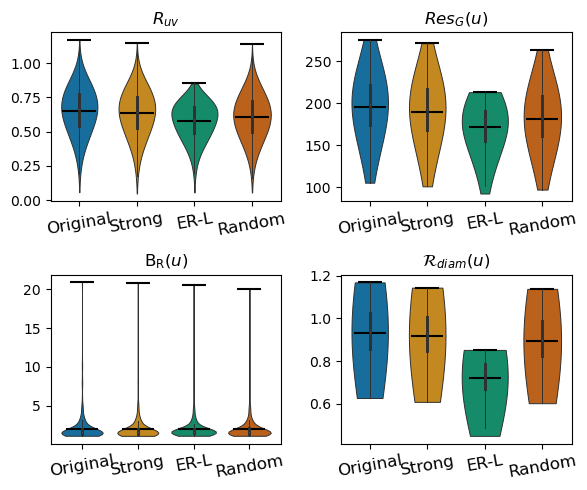

In [393]:
vis.plot_violins_node_metrics(df_res, df_total, df_tot_filter, df_diam)

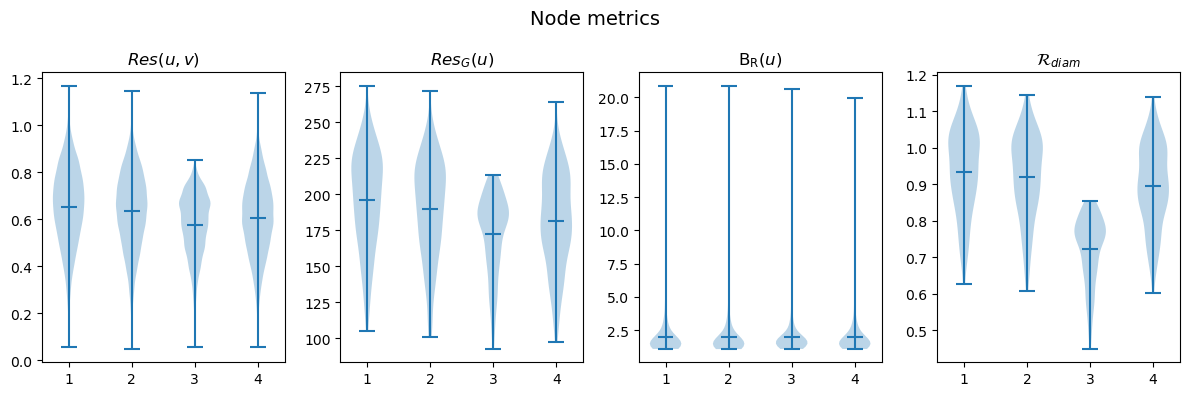

In [394]:
f, axs = plt.subplots(1,4, figsize=(12,4))

axs[0].set_title('$Res(u,v)$')
axs[0].violinplot(all_res, showmeans = True)

axs[1].set_title('$Res_G(u)$')
axs[1].violinplot(all_total_res, showmeans = True)

axs[2].set_title('$\mathsf{B_R}(u)$')
axs[2].violinplot(all_filtered_res, showmeans = True)

axs[3].set_title('$\mathcal{R}_{diam}$')
axs[3].violinplot(all_diam_res, showmeans = True)

plt.suptitle('Node metrics', fontsize=14)
plt.tight_layout()
plt.show()

**Decreasing rate Average about number of different iterations**

In [ ]:
n_iterations = 100
n_links = 100

metrics = ['total', 'diam', 'avg_diam', 'max_bet', 'avg_bet', 'std_bet']
all_intra_data = {k:np.empty((0, n_links+1)) for k in metrics}
all_inter_data = {k:np.empty((0, n_links+1)) for k in metrics}
all_rand_data = {k:np.empty((0, n_links+1)) for k in metrics}

for i in tqdm(range(n_iterations)):
    print(i, end='')
    if i%10==9:print()
    G = nx.powerlaw_cluster_graph(300, 3, .95)
    _,_,_, iter_intra_data, iter_inter_data, iter_rand_data = add_edges_dynamic(G, n_links, ratio=1, rand=True)
    for k in all_intra_data:
        
        all_intra_data[k] = np.vstack((all_intra_data[k], np.array(iter_intra_data[k])))
        all_inter_data[k] = np.vstack((all_inter_data[k], np.array(iter_inter_data[k])))
metrics = ['total', 'diam', 'std_bet']#, 'avg_bet', 'avg_diam', 'max_bet']        all_rand_data[k] = np.vstack((all_rand_data[k], np.array(iter_rand_data[k])))

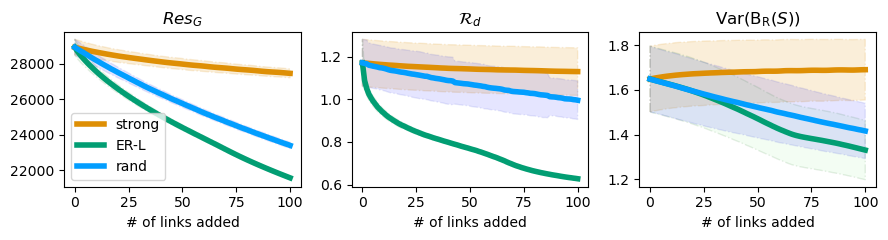

In [253]:
metrics = ['total', 'diam', 'std_bet']#, 'avg_bet', 'avg_diam', 'max_bet']


f, axs = plt.subplots(int(np.ceil(len(metrics)/3)),3,
                      figsize=(9,2.5*int(np.ceil(len(metrics)/3))))
axs = axs.ravel()

orange = (222/255,143/255,5/255)
green = (2/255,158/255,115/255)

metric_name = {'total':'$Res_G$',
               'diam': '$\mathcal{R}_{d}$',
               'avg_diam':'$\overline{\mathcal{R}_{diam}(S)}$',
               'max_bet':'Max $\mathsf{B_R}(S)$',
               'avg_bet':'$\mathsf{B_R}(V)$',
               'std_bet':'Var$(\mathsf{B_R}(S))$'
    
}

for idx, m in enumerate(metrics):
    axs[idx].set_title(metric_name[m])
    axs[idx].set_xlabel('# of links added') 

    total_intra_mean = all_intra_data[m].mean(axis=0)
    total_inter_mean = all_inter_data[m].mean(axis=0)
    total_rand_mean = all_rand_data[m].mean(axis=0)
    total_intra_std = all_intra_data[m].std(axis=0)
    total_inter_std = all_inter_data[m].std(axis=0)
    total_rand_std = all_rand_data[m].std(axis=0)
    axs[idx].plot(total_intra_mean,label='strong', linewidth=4, color=orange)
    axs[idx].fill_between(range(n_links+1),
                          total_intra_mean+total_intra_std,
                          total_intra_mean-total_intra_std,
                          linestyle='dashdot',
                          color=orange, alpha=0.15)

    axs[idx].plot(total_inter_mean, label='ER-L', linewidth=4, color=green)
    axs[idx].fill_between(range(n_links+1),
                          total_inter_mean+total_inter_std,
                          total_inter_mean-total_inter_std,
                          linestyle='dashdot',
                          edgecolor='darkgreen',
                          facecolor='lightgreen', alpha=0.1)

    axs[idx].plot(total_rand_mean, label='rand', linewidth=4, color=blue)
    axs[idx].fill_between(range(n_links+1),
                     total_rand_mean+total_rand_std,
                     total_rand_mean-total_rand_std,
                       edgecolor='#1B2ACC', facecolor='blue', 
                          linestyle='dashdot', antialiased=True,
                          alpha=.1), #alpha=.15)

    #axs[idx].axhline(np.min([np.min(total_inter_mean),np.min(total_intra_mean)]),color='green')
    if idx==0: axs[idx].legend()


plt.tight_layout()
plt.show()

In [254]:
#f.savefig('figs/RewiredTransitionCPA.pdf', dpi=300, bbox_inches='tight')

# Subgroups

Load Graph: Synthetic

In [92]:
G = nx.Graph()
G.add_edges_from([(0,1),(0,3),(1,2),(1,3),(1,4),(2,4),(2,11),(3,4),(3,5),
                  (4,5),(5,6),(5,7),(6,7),(6,8),(6,9), (7,9),(7,10),(8,9),
                  (9,10),(10,15),(11,12),(12,13),(13,14),(14,15),(0,11),(8,15)])

sensitive_group = np.array([0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0])
pos= nx.kamada_kawai_layout(G)

In [88]:
sensitive_group = np.array([])

for ix, s in enumerate(sizes):
    
    s_c = np.array([group_by_com[ix]]*s)
    if noises[ix] !=0:
        idx = np.random.choice(s,int(s*noises[ix]),replace=False)
        idx = np.random.choice(range(s)) if len(idx)==0 else idx
        s_c[idx] = 1 - s_c[idx]
    sensitive_group = np.hstack([sensitive_group, s_c])

In [93]:
R = ermet.effective_resistance_matrix(G)
evl, evc = find_evecs(nx.laplacian_matrix(G))
evl = np.real(evl)
evc = np.real(evc)

In [94]:
ermet.group_total_reff(R, sensitive_group)

{0: 17.205860805860816, 1: 21.276190476190486}

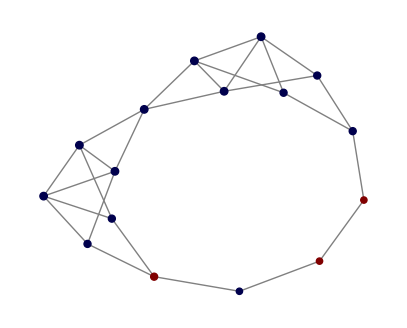

In [95]:
f, axs = plt.subplots(1, figsize=(5,4))
options = {
    "node_color": sensitive_group,
    "edge_color": 'grey',
    "width": 1,
    "node_size":(np.log(np.array([itm[1] for itm in dict(G.degree).items()]))+1)*12,
    #"node_size":20,
    "edge_cmap": plt.cm.seismic,
    "cmap": plt.cm.seismic,
    "with_labels": False,
}
nx.draw(G, pos, **options,ax=axs)
plt.show()

In [96]:
init_total= ermet.group_total_reff(R, sensitive_group)
init_diam= ermet.group_reff_diam(R, sensitive_group)
init_avg_diam = ermet.group_avg_reff_diam(R, sensitive_group)
init_max_bet = ermet.group_max_reff_betweeness(R, G, sensitive_group)
init_avg_bet = ermet.group_avg_reff_betweeness(R, G, sensitive_group)
init_std_bet = ermet.group_std_reff_betweeness(R, G, sensitive_group)

ori_metric_dict = {'total':init_total,
                   'diam':init_diam,
                    'avg_diam':init_avg_diam,
                    'max_bet' :init_max_bet,
                    'avg_bet':init_avg_bet,
                    'std_bet':init_std_bet}

print(f"""
Total Res: 0-> {init_total[0]:.2f}  --  1-> {init_total[1]:.2f} 
Diam Res: 0-> {init_diam[0]:.2f}  --  1-> {init_diam[1]:.2f} 
AVG Diam: 0-> {init_avg_diam[0]:.2f}  --  1-> {init_avg_diam[1]:.2f}

Max Bet: 0-> {init_max_bet[0]:.2f}  --  1-> {init_max_bet[1]:.2f} 
AVG Bet: 0-> {init_avg_bet[0]:.2f}  --  1-> {init_avg_bet[1]:.2f} 
STD Bet: 0-> {init_std_bet[0]:.2f}  --  1-> {init_std_bet[1]:.2f} 
""")


Total Res: 0-> 17.21  --  1-> 21.28 
Diam Res: 0-> 1.84  --  1-> 1.84 
AVG Diam: 0-> 1.78  --  1-> 1.75

Max Bet: 0-> 2.28  --  1-> 2.13 
AVG Bet: 0-> 1.88  --  1-> 1.84 
STD Bet: 0-> 0.18  --  1-> 0.20 



In [97]:
def add_links(G, number_of_edges, S, ratio=1, rand = False):
    def create_dicts(keys):
        return {key: [] for key in keys}
    
    def add_metrics(R, S, G, met_dict):
        total= ermet.group_total_reff(R, S)
        diam= ermet.group_reff_diam(R, S)
        avg_diam = ermet.group_avg_reff_diam(R, S)
        max_bet = ermet.group_max_reff_betweeness(R, G, S)
        avg_bet = ermet.group_avg_reff_betweeness(R, G, S)
        std_bet = ermet.group_std_reff_betweeness(R, G, S)
        #save data
        met_dict["total"].append(total)
        met_dict["diam"].append(diam)
        met_dict["avg_diam"].append(avg_diam)
        met_dict["max_bet"].append(max_bet)
        met_dict["avg_bet"].append(avg_bet)
        met_dict["std_bet"].append(std_bet)
        
    
    metrics = ['total', 'diam', 'avg_diam', 'max_bet', 'avg_bet', 'std_bet']
    strong_data = create_dicts(metrics)
    rand_data = create_dicts(metrics)
    weak_data = create_dicts(metrics)
    aff_weak_data = create_dicts(metrics)
    aff_strong_data = create_dicts(metrics)
    
    G_strong = G.copy()
    G_rand = G.copy()
    G_weak = G.copy()
    
    G_aff_weak= G.copy()
    G_aff_strong = G.copy()
        
    for i in tqdm(range(number_of_edges+1)):        
        #Strong
        cos_res_strong = ermet.effective_resistance_matrix(G_strong)
        add_metrics(cos_res_strong, S, G_strong, strong_data) 

        #Random
        if rand:
            cos_res_rand = ermet.effective_resistance_matrix(G_rand)
            add_metrics(cos_res_rand, S, G_rand, rand_data) 
        
        
        if i % ratio == 0:
            ## WEAK ======================================
            cos_res_weak = ermet.effective_resistance_matrix(G_weak)
            add_metrics(cos_res_weak, S, G_weak, weak_data) 
            
            ## WEAK AA ======================================
            cos_res_aff_weak = ermet.effective_resistance_matrix(G_aff_weak)
            add_metrics(cos_res_aff_weak, S, G_aff_weak, aff_weak_data)
            
            ## STRONG AA ======================================
            cos_res_aff_strong = ermet.effective_resistance_matrix(G_aff_strong)
            add_metrics(cos_res_aff_strong, S, G_aff_strong, aff_strong_data)
            
            ## Walk Strong ======================================
            
        
        #add links
        G_strong = rew.add_strong_link(G_strong, cos_res_strong)
        if rand:
            G_rand = rew.add_rand_link(G_rand, cos_res_rand)
        if i % ratio == 0:
            G_weak = rew.add_weak_link(G_weak, cos_res_weak)
            G_aff_weak = rew.add_weak_affirmative_link(G_aff_weak, CT = cos_res_aff_weak, S=S)
            G_aff_strong = rew.add_strong_affirmative_link(G_aff_strong, CT =  cos_res_aff_strong, S=S)
        
    add_metrics(ermet.effective_resistance_matrix(G_strong), S, G_strong, strong_data)
    add_metrics(ermet.effective_resistance_matrix(G_weak), S, G_weak, weak_data) 
    add_metrics(ermet.effective_resistance_matrix(G_aff_weak), S, G_aff_weak, aff_weak_data)
    add_metrics(ermet.effective_resistance_matrix(G_aff_strong), S, G_aff_strong, aff_strong_data)
    if rand:
        return G_strong, G_weak, G_rand, strong_data, weak_data, rand_data
    else:
        return [G_strong, G_weak, G_aff_weak, G_aff_strong], [strong_data, weak_data, aff_weak_data, aff_strong_data]

In [99]:
N_LINKS = 5
Graphs, data = add_links(G, N_LINKS, sensitive_group)
G_s, G_w, G_aw, G_as = Graphs
d_s, d_w, d_aw, d_as = data

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 185.36it/s]


In [100]:
G.number_of_edges(),G_s.number_of_edges(),G_w.number_of_edges(), G_aw.number_of_edges(), G_as.number_of_edges()

(26, 32, 32, 32, 32)

In [101]:
methods = ['strong', 'ER-L', 'ERA-L', 'St-AA']
colors = {'strong': 'red', 'ER-L':'blue', 'ERA-L':'green','St-AA':'orange'}
metrics = ['total', 'diam', 'avg_diam', 'max_bet', 'avg_bet', 'std_bet']
result_dict = dict(zip(methods,data))

In [102]:
plt.rcParams['font.family'] = ['sans-serif']

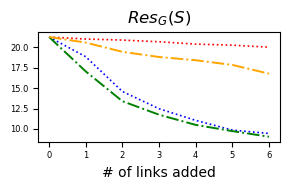

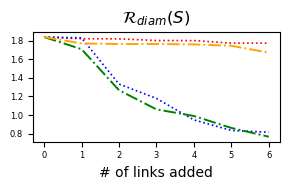

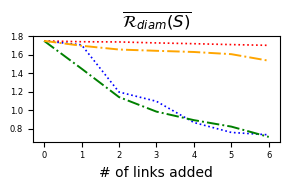

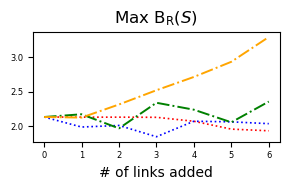

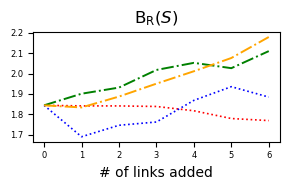

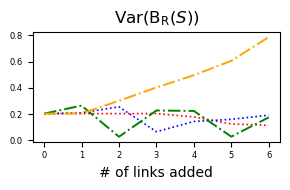

In [103]:
from matplotlib.lines import Line2D   
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

metric_name = {'total':'$Res_G(S)$',
               'diam': '$\mathcal{R}_{diam}(S)$',
               'avg_diam':'$\overline{\mathcal{R}_{diam}(S)}$',
               'max_bet':'Max $\mathsf{B_R}(S)$',
               'avg_bet':'$\mathsf{B_R}(S)$',
               'std_bet':'Var$(\mathsf{B_R}(S))$'
    
}
for metric in metrics:
    f, axs = plt.subplots(1, figsize=(3,2))
    for alg in methods:
        if alg=='ER-L' or alg=='strong':
            lw = 1.2
            ls = "dotted"
        else:
            lw = 1.4
            ls="dashdot"
        #plt.plot([d[0] for d in result_dict[alg][metric]],linewidth=lw, color=colors[alg], linestyle="-")
        plt.plot([d[1] for d in result_dict[alg][metric]], linewidth=lw, color=colors[alg], linestyle=ls)
        axs.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        axs.tick_params(axis='both', which='major', labelsize=6)
        
    legend_elements = [Line2D([0], [0], linestyle='-', color='black', label=r'$Res_G(Oth)$',linewidth='2'),
                   Line2D([0], [0], linestyle='--', color='black', label='$Res_G(Vuln)$',linewidth='2'),
                   Line2D([0], [0], linestyle='-', color='red', label='Common',linewidth='5'),
                   Line2D([0], [0], linestyle='-', color='orange', label='SAA',linewidth='5'),
                   Line2D([0], [0], linestyle='-', color='blue', label='Weak',linewidth='5'),
                   Line2D([0], [0], linestyle='-', color='green', label='AAA',linewidth='5')
                  ]
    legend_elements = [Line2D([0], [0], linestyle='dashdot', color='green', label=r'ERA-L',linewidth='2'),
                   Line2D([0], [0], linestyle='dashdot', color='orange', label='St-AA',linewidth='2'),
                   Line2D([0], [0], linestyle='dotted', color='red', label='Strong',linewidth='2'),
                       Line2D([0], [0], linestyle='dotted', color='blue', label='ER-L',linewidth='2')
                  ]
    
    #plt.legend(handles=legend_elements, bbox_to_anchor=(1.0, 0.9), loc="upper left", fontsize=9)
    #plt.ylabel(metric_name[metric])
    plt.xlabel('# of links added')
    plt.title(metric_name[metric])
    plt.tight_layout()
    #f.savefig(f'figs/FB500{metric}Evolution.pdf', dpi=300, bbox_inches='tight', transparent=True)
    plt.show()

**DeepWalk**

In [104]:
dw_s_metrics={}
dw_s_metrics={}

In [105]:
from karateclub import DeepWalk
#https://towardsdatascience.com/introduction-to-graph-neural-networks-with-deepwalk-f5ac25900772

G_dw_s = G.copy()
#G_dw_s = nx.relabel_nodes(G_dw_s, {node:ix for ix, node in enumerate(G_dw_s.nodes())}, copy=False)

for i in tqdm(range(N_LINKS)):
    dw = DeepWalk(dimensions=32)
    dw.fit(G_dw_s.copy())
    Z = dw.get_embedding()
    S = np.dot(Z, Z.T)
    np.fill_diagonal(S,0)
    G_dw_s = rew.add_weak_link(G_dw_s, CT=S)
    R = ermet.effective_resistance_matrix(G_dw_s)
    
    
G_dw_w = G.copy()
#G_dw_w = nx.relabel_nodes(G_dw_w, {node:ix for ix, node in enumerate(G_dw_w.nodes())}, copy=False)
for i in tqdm(range(N_LINKS+1)):
    dw = DeepWalk(dimensions=32)
    dw.fit(G_dw_w.copy())
    Z = dw.get_embedding()
    S = np.dot(Z, Z.T)
    np.fill_diagonal(S,0)
    G_dw_w = rew.add_strong_link(G_dw_w, CT=S)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 25.94it/s]


**Mejora de las medidas**

In [106]:
final_result_dict = {}

for a in result_dict:
    final_result_dict[a]={}
    for m in result_dict[a]:
        final_result_dict[a][m]={}
        final_result_dict[a][m][0]=result_dict[a][m][-1][0]
        final_result_dict[a][m][1]=result_dict[a][m][-1][1]

orig_metric_dict = {}
orig_metric_dict['ST-DW']={}
orig_metric_dict['w-DW']={}
for a in result_dict:
    orig_metric_dict[a]={}
    for m in result_dict[a]:
        orig_metric_dict[a][m]={}
        orig_metric_dict[a][m][0]=result_dict[a][m][0][0]
        orig_metric_dict[a][m][1]=result_dict[a][m][0][1]
        
        orig_metric_dict['ST-DW'][m]=orig_metric_dict['w-DW'][m]={}
        orig_metric_dict['ST-DW'][m][0]=orig_metric_dict['w-DW'][m][0]=result_dict[a][m][0][0]
        orig_metric_dict['ST-DW'][m][1]=orig_metric_dict['w-DW'][m][1]=result_dict[a][m][0][1]

In [107]:
import pandas as pd

In [108]:
final_metric_df = pd.DataFrame.from_dict({(i,j): final_result_dict[i][j] 
                           for i in final_result_dict.keys() 
                           for j in final_result_dict[i].keys()},
                       orient='index')
orig_metric_df = pd.DataFrame.from_dict({(i,j): orig_metric_dict[i][j] 
                           for i in orig_metric_dict.keys() 
                           for j in orig_metric_dict[i].keys()},
                       orient='index')

In [109]:
R = ermet.effective_resistance_matrix(G_dw_s)
final_metric_df.loc[('ST-DW','total'), 0] = ermet.group_total_reff(R, sensitive_group)[0]
final_metric_df.loc[('ST-DW','total'), 1] = ermet.group_total_reff(R, sensitive_group)[1]
final_metric_df.loc[('ST-DW','diam'), 0] = ermet.group_reff_diam(R, sensitive_group)[0]
final_metric_df.loc[('ST-DW','diam'), 1] = ermet.group_reff_diam(R, sensitive_group)[1]
final_metric_df.loc[('ST-DW','avg_bet'), 0] = ermet.group_avg_reff_betweeness(R,
                                                                              G_dw_s, 
                                                                              sensitive_group)[0]
final_metric_df.loc[('ST-DW','avg_bet'), 1] = ermet.group_avg_reff_betweeness(R,
                                                                              G_dw_s,
                                                                              sensitive_group)[1]
final_metric_df.loc[('ST-DW','std_bet'), 0] = ermet.group_std_reff_betweeness(R,
                                                                              G_dw_s,
                                                                              sensitive_group)[0]
final_metric_df.loc[('ST-DW','std_bet'), 1] = ermet.group_std_reff_betweeness(R,
                                                                              G_dw_s,
                                                                              sensitive_group)[1]


R = ermet.effective_resistance_matrix(G_dw_w)
final_metric_df.loc[('w-DW','total'), 0] = ermet.group_total_reff(R, sensitive_group)[0]
final_metric_df.loc[('w-DW','total'), 1] = ermet.group_total_reff(R, sensitive_group)[1]
final_metric_df.loc[('w-DW','diam'), 0] = ermet.group_reff_diam(R, sensitive_group)[0]
final_metric_df.loc[('w-DW','diam'), 1] = ermet.group_reff_diam(R, sensitive_group)[1]
final_metric_df.loc[('w-DW','avg_bet'), 0] = ermet.group_avg_reff_betweeness(R,
                                                                              G_dw_w, 
                                                                              sensitive_group)[0]
final_metric_df.loc[('w-DW','avg_bet'), 1] = ermet.group_avg_reff_betweeness(R,
                                                                              G_dw_w,
                                                                              sensitive_group)[1]
final_metric_df.loc[('w-DW','std_bet'), 0] = ermet.group_std_reff_betweeness(R,
                                                                              G_dw_w,
                                                                              sensitive_group)[0]
final_metric_df.loc[('w-DW','std_bet'), 1] = ermet.group_std_reff_betweeness(R,
                                                                              G_dw_w,
                                                                              sensitive_group)[1]

In [110]:
table = final_metric_df -orig_metric_df
#table = ((final_metric_df -orig_metric_df)/orig_metric_df)*100
#table = ((orig_metric_df-final_metric_df)/orig_metric_df)*100

table = table[np.in1d(table.index.get_level_values(1), ['total', 'diam', 'avg_bet', 'std_bet'])]
table

0          1
ER-L   avg_bet -0.009357   0.040549
       diam    -1.013514  -1.026127
       std_bet -0.030017  -0.011482
       total   -7.963020 -11.829710
ERA-L  avg_bet -0.061494   0.266475
       diam    -0.931869  -1.074852
       std_bet -0.033854  -0.028127
       total   -7.396867 -12.231093
ST-DW  avg_bet  0.050500  -0.218835
       diam    -0.597333  -0.553730
       std_bet  0.104317  -0.060263
       total   -5.647113  -7.108784
St-AA  avg_bet -0.077493   0.335801
       diam    -0.168907  -0.168907
       std_bet  0.108776   0.582526
       total   -4.046816  -4.496986
strong avg_bet  0.017296  -0.074950
       diam    -0.066071  -0.066071
       std_bet  0.001669  -0.088318
       total   -2.002335  -1.247024
w-DW   avg_bet  0.022097  -0.095752
       diam    -0.385982  -0.385982
       std_bet  0.048084   0.099142
       total   -6.994942  -6.518186

Vulnerable Group

In [111]:
group1_df = pd.DataFrame(table[1]).reset_index().pivot(index='level_0', columns='level_1')[1]
group1_df = group1_df.loc[['ST-DW','strong','St-AA','w-DW','ER-L','ERA-L']]
print(group1_df[['total', 'diam', 'avg_bet', 'std_bet']].round(3).to_latex())
group1_df[['total', 'diam', 'avg_bet', 'std_bet']]

\begin{tabular}{lrrrr}
\toprule
level\_1 &   total &   diam &  avg\_bet &  std\_bet \\
level\_0 &         &        &          &          \\
\midrule
ST-DW   &  -7.109 & -0.554 &   -0.219 &   -0.060 \\
strong  &  -1.247 & -0.066 &   -0.075 &   -0.088 \\
St-AA   &  -4.497 & -0.169 &    0.336 &    0.583 \\
w-DW    &  -6.518 & -0.386 &   -0.096 &    0.099 \\
ER-L    & -11.830 & -1.026 &    0.041 &   -0.011 \\
ERA-L   & -12.231 & -1.075 &    0.266 &   -0.028 \\
\bottomrule
\end{tabular}



level_1      total      diam   avg_bet   std_bet
level_0                                         
ST-DW    -7.108784 -0.553730 -0.218835 -0.060263
strong   -1.247024 -0.066071 -0.074950 -0.088318
St-AA    -4.496986 -0.168907  0.335801  0.582526
w-DW     -6.518186 -0.385982 -0.095752  0.099142
ER-L    -11.829710 -1.026127  0.040549 -0.011482
ERA-L   -12.231093 -1.074852  0.266475 -0.028127

Other group

In [112]:
group0_df = pd.DataFrame(table[0]).reset_index().pivot(index='level_0', columns='level_1')[0]
group0_df = group0_df.loc[['ST-DW','strong','St-AA','w-DW','ER-L','ERA-L']]
print(group0_df[['total', 'diam', 'avg_bet', 'std_bet']].round(3).to_latex())
group0_df[['total', 'diam', 'avg_bet', 'std_bet']]

\begin{tabular}{lrrrr}
\toprule
level\_1 &  total &   diam &  avg\_bet &  std\_bet \\
level\_0 &        &        &          &          \\
\midrule
ST-DW   & -5.647 & -0.597 &    0.051 &    0.104 \\
strong  & -2.002 & -0.066 &    0.017 &    0.002 \\
St-AA   & -4.047 & -0.169 &   -0.077 &    0.109 \\
w-DW    & -6.995 & -0.386 &    0.022 &    0.048 \\
ER-L    & -7.963 & -1.014 &   -0.009 &   -0.030 \\
ERA-L   & -7.397 & -0.932 &   -0.061 &   -0.034 \\
\bottomrule
\end{tabular}



level_1     total      diam   avg_bet   std_bet
level_0                                        
ST-DW   -5.647113 -0.597333  0.050500  0.104317
strong  -2.002335 -0.066071  0.017296  0.001669
St-AA   -4.046816 -0.168907 -0.077493  0.108776
w-DW    -6.994942 -0.385982  0.022097  0.048084
ER-L    -7.963020 -1.013514 -0.009357 -0.030017
ERA-L   -7.396867 -0.931869 -0.061494 -0.033854

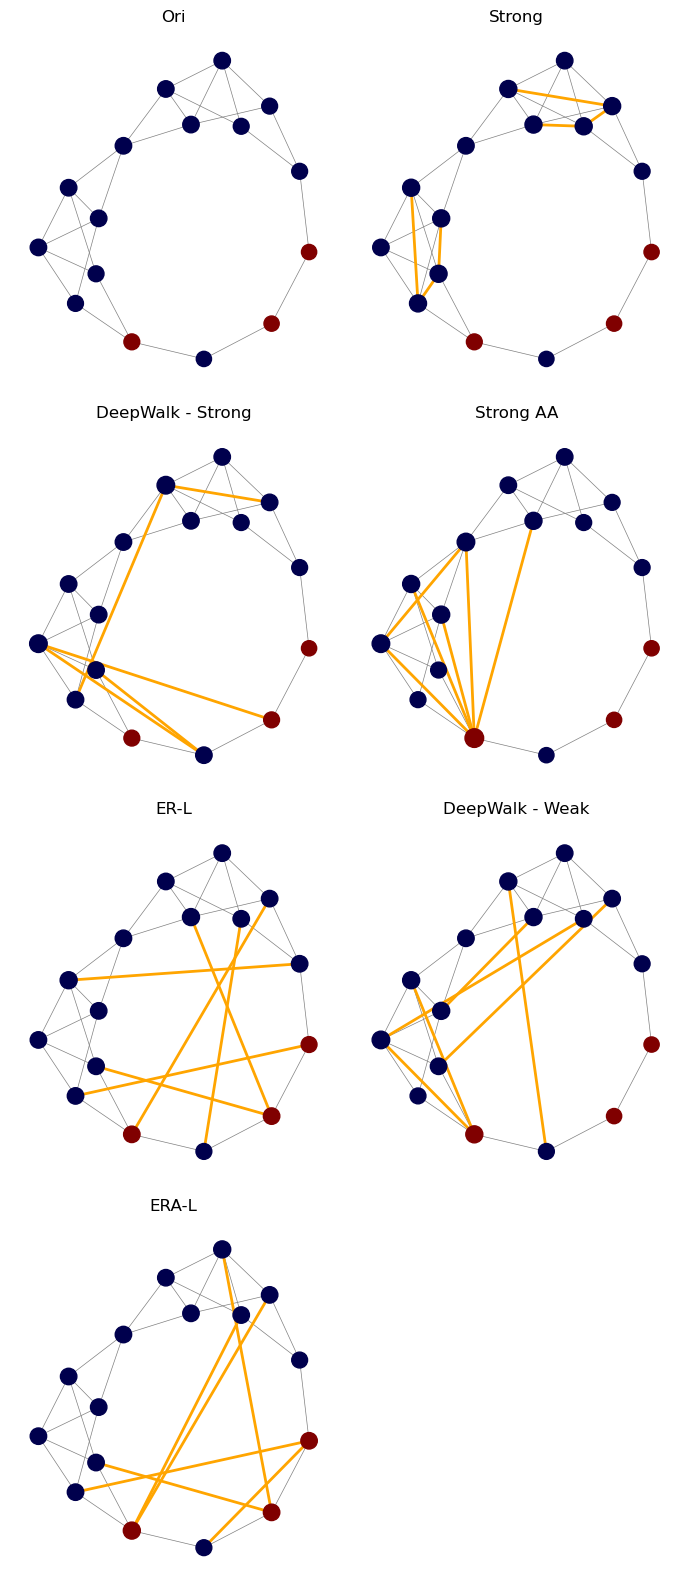

In [114]:
f = vis.print_several_graphs([G, G_s, G_dw_s, G_as, G_w, G_dw_w, G_aw],
                     node_color=sensitive_group,
                     base_G=0,
                     names=['Ori' ,'Strong', 'DeepWalk - Strong', 'Strong AA',
                            'ER-L', 'DeepWalk - Weak', 'ERA-L'],
                     node_size=10,
                     pos=pos)

In [115]:
#f.savefig('figs/SynthRewired.pdf', dpi=300, bbox_inches='tight')

**Compare graphs visialization**

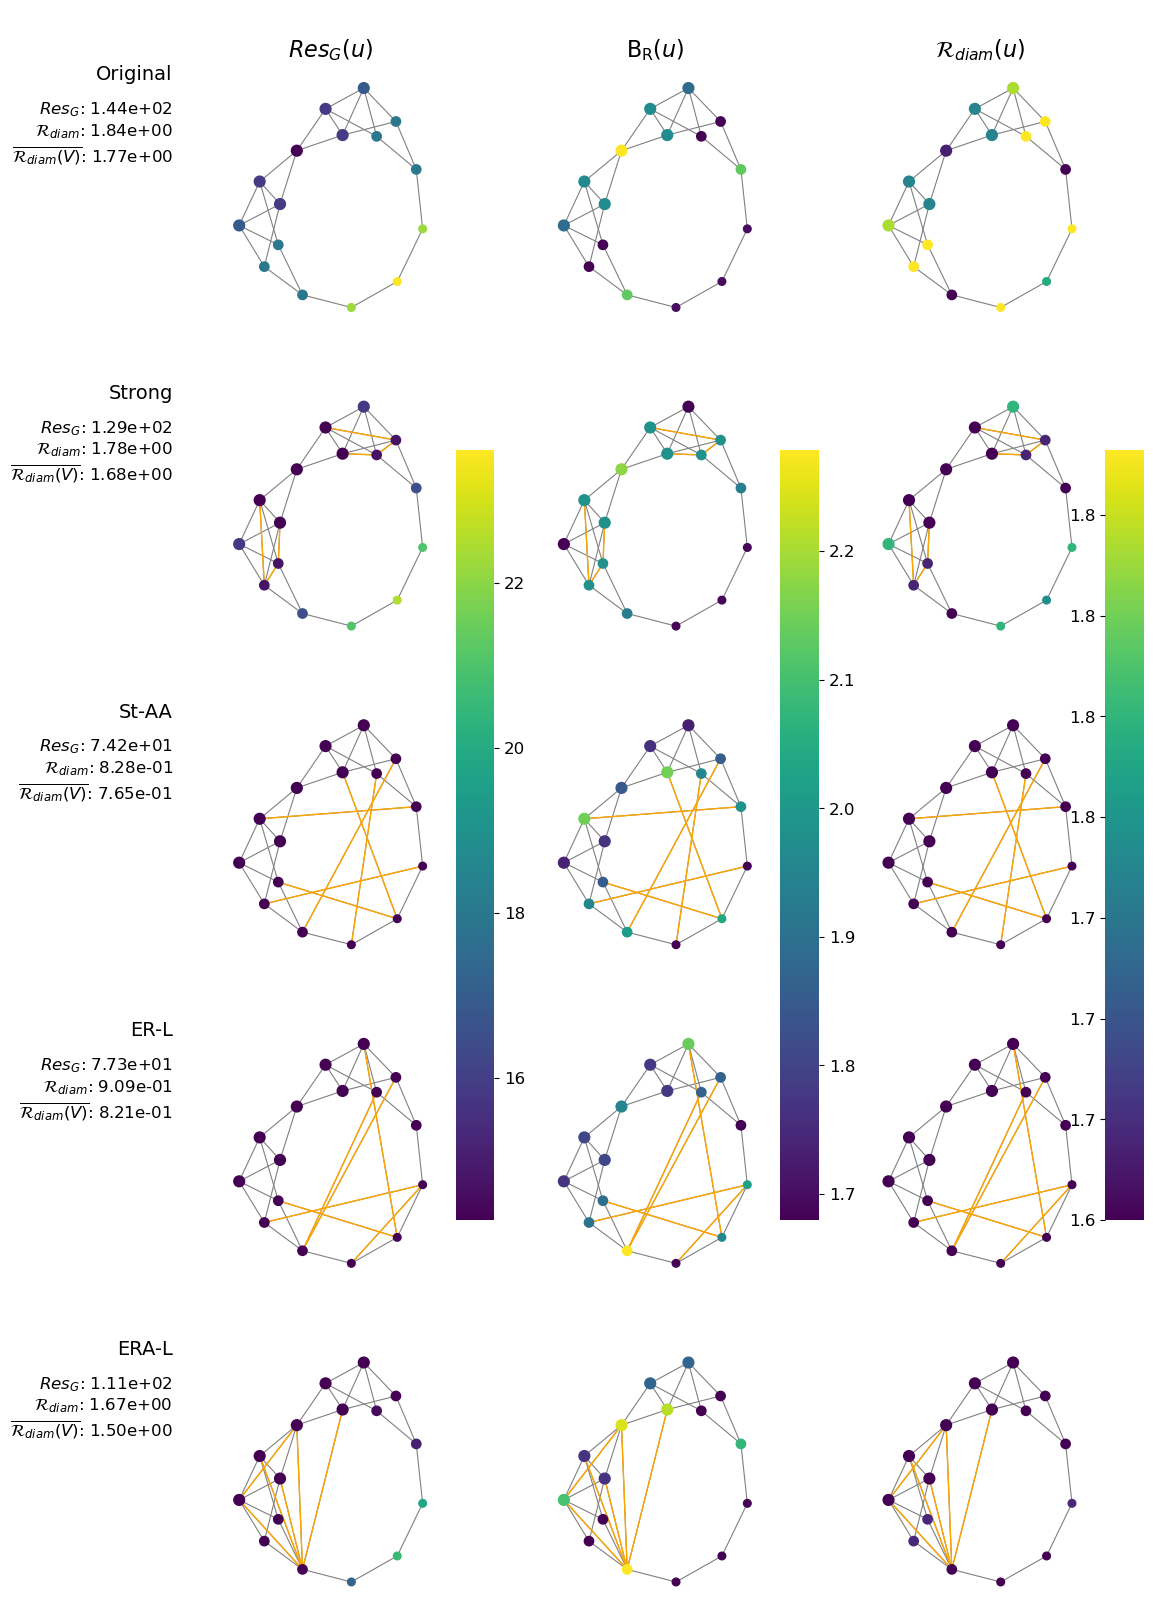

In [118]:
vis.compare_graphs([G, G_s, G_w, G_aw, G_as],
               graph_names=['Original', 'Strong', 'St-AA', 'ER-L', 'ERA-L',], 
              edge_highlight=True, node_size=15,
              save=False)

**Violinplots**

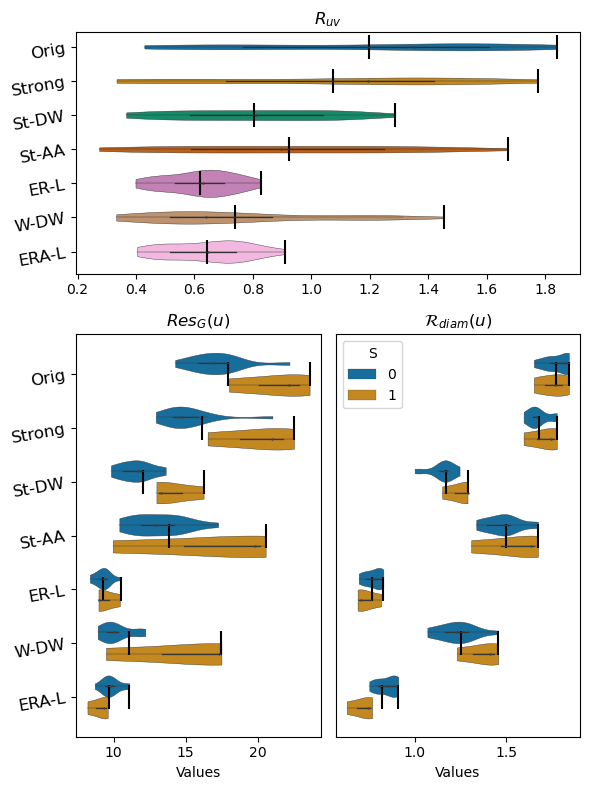

In [119]:
ff, asx = vis.plot_violins_node_metrics_by_group2([G, G_s, G_dw_s, G_as, G_w, G_dw_w, G_aw],
                                                 names=['Orig','Strong', 'St-DW', 'St-AA',
                                                        'ER-L', 'W-DW','ERA-L'],
                                                 S=sensitive_group,
                                                 orient='h',
                                                 fig_size=(6,8))
#ff.savefig('figs/FbViolinplots.pdf', dpi=300, bbox_inches='tight')

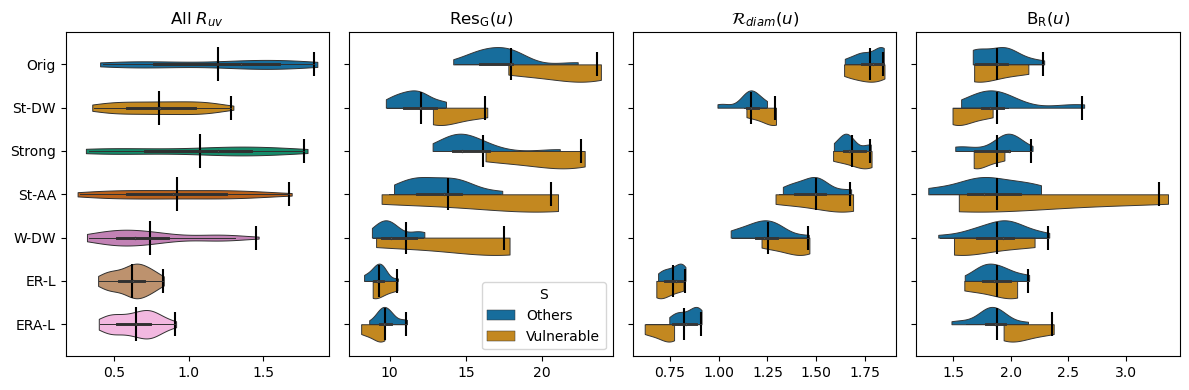

In [120]:
f,_ = vis.plot_violins_node_metrics_by_group([G, G_dw_s, G_s, G_as, G_dw_w, G_w, G_aw],
                                             names=['Orig','St-DW','Strong',
                                                    'St-AA', 'W-DW','ER-L','ERA-L'],
                                             S=sensitive_group,
                                             orient='h',
                                             plot_max_avg_lines=True,
                                            fig_size=(12,4))
#f.savefig('figs/FB500Violinplots.pdf', dpi=300, bbox_inches='tight')

In [258]:
df = pd.read_csv(r'data\pokec_regions\region_job.csv', index_col=0)
pokek = nx.read_edgelist(r'data\pokec_regions\region_job_relationship.txt')
pokek = nx.relabel_nodes(pokek, {node:int(node) for node in pokek.nodes()}, copy=True)

In [268]:
pokek.number_of_nodes(), pokek.number_of_edges(), nx.number_connected_components(pokek)

(67796, 617958, 170)

In [266]:
nx.set_node_attributes(pokek, dict(df['gender']), name='sens')
nx.set_node_attributes(pokek, dict(df['region']), name='region')

In [279]:
Gcc = sorted(nx.connected_components(pokek), key=len, reverse=True)

In [280]:
G_pokek_con = nx.Graph(pokek.subgraph(Gcc[0]).copy())

In [286]:
G = nx.relabel_nodes(G_pokek_con, {node:ix for ix, node in enumerate(G_pokek_con.nodes())}, copy=True)

In [287]:
G.nodes(data=True)

NodeDataView({0: {'sens': 1.0, 'region': 0}, 1: {'sens': 0.0, 'region': 0}, 2: {'sens': 1.0, 'region': 0}, 3: {'sens': 1.0, 'region': 0}, 4: {'sens': 0.0, 'region': 1}, 5: {'sens': 0.0, 'region': 0}, 6: {'sens': 1.0, 'region': 0}, 7: {'sens': 0.0, 'region': 0}, 8: {'sens': 0.0, 'region': 0}, 9: {'sens': 1.0, 'region': 0}, 10: {'sens': 0.0, 'region': 0}, 11: {'sens': 0.0, 'region': 0}, 12: {'sens': 0.0, 'region': 0}, 13: {'sens': 0.0, 'region': 1}, 14: {'sens': 1.0, 'region': 0}, 15: {'sens': 1.0, 'region': 1}, 16: {'sens': 0.0, 'region': 0}, 17: {'sens': 0.0, 'region': 1}, 18: {'sens': 0.0, 'region': 0}, 19: {'sens': 1.0, 'region': 1}, 20: {'sens': 0.0, 'region': 1}, 21: {'sens': 1.0, 'region': 0}, 22: {'sens': 0.0, 'region': 0}, 23: {'sens': 0.0, 'region': 1}, 24: {'sens': 1.0, 'region': 1}, 25: {'sens': 0.0, 'region': 1}, 26: {'sens': 1.0, 'region': 0}, 27: {'sens': 1.0, 'region': 0}, 28: {'sens': 0.0, 'region': 0}, 29: {'sens': 0.0, 'region': 0}, 30: {'sens': 0.0, 'region': 0}, 31: 

In [294]:
list(nx.get_node_attributes(G, 'sens').values())

True

In [295]:
list(nx.get_node_attributes(G_pokek_con, 'sens').values())

[1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0

In [303]:
df = pd.read_csv(r'data\pokec_regions\region_job_2.csv', index_col=0)
pokek = nx.read_edgelist(r'data\pokec_regions\region_job_2_relationship.txt')
pokek = nx.relabel_nodes(pokek, {node:int(node) for node in pokek.nodes()}, copy=True) #str to int
nx.set_node_attributes(pokek, dict(df['gender']), name='sens')
nx.set_node_attributes(pokek, dict(df['region']), name='region')

print(pokek.number_of_nodes())

Gcc = sorted(nx.connected_components(pokek), key=len, reverse=True)
G = nx.Graph(pokek.subgraph(Gcc[0]).copy())
del pokek
del df
G = nx.relabel_nodes(G, {node:ix for ix, node in enumerate(G.nodes())}, copy=True) # from 0 to n: simplify adding edges

sensitive_group = nx.get_node_attributes(G, 'sens')
# sensitive group to numpy array
sensitive_group = np.array(list(sensitive_group.values()))

66569


In [307]:
G.number_of_edges()

516784

In [323]:
A = np.ones((67435,67435), dtype='float16')

In [ ]:
R